####  Author: Samaneh Bidabadi
#### Date:   16/12/ 2022
#### MIMO OFDM Wireless Communications with Matlab 

#### imports

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
import scipy
import math
import operator

# chapter 1

program 1.2 “PL_free” for free-space path loss model

In [ ]:
def PL_free(fc, dist, Gt=None, Gr=None):
    """
    Program 1.2
    Free Space Path loss Model

    :param fc: carrier frequency[Hz]
    :param dist: between base station and mobile station[m]
    :param Gt: transmitter gain
    :param Gr: receiver gain
    :return: path loss[dB]
    """
    lamda = 3e8 / fc
    tmp = lamda / (4 * np.pi * dist)
    if Gt is not None:
        tmp = tmp * np.sqrt(Gt)
    if Gr is not None:
        tmp = tmp * np.sqrt(Gr)
    PL = -20 * np.log10(tmp)  # Eq.(1.2) / (1.3)

    return PL

program 1.1 “PL_logdist_or_norm” for log-distance/normal shadowing path loss model

In [3]:
def PL_logdist_or_norm(fc, d, d0, n, sigma=None):
    """
    Program 1.1
    Log-distance or Log-normal Shadowing Path Loss model

    :param fc: carrier frequency[Hz]
    :param d: between base station and mobile station[m]
    :param d0: reference distance[m]
    :param n: path loss exponent, n
    :param sigma: variance[dB]
    :return: path loss[dB]
    """
    lamda = 3e8 / fc
    PL = -20 * np.log10(lamda / (4 * np.pi * d0)) + 10 * n * np.log10(d / d0)  # Eq.(1.4)
    if sigma is not None:
        # TODO check d.shape

        if len(d.shape) == 1:
            r1 = np.random.randn(d.shape[0])
        elif len(d.shape) == 2:
            r1 = np.random.randn(d.shape[0], d.shape[1])
        else:
            r1 = np.random.randn(d.shape[0], d.shape[1], d.shape[2])
        PL = PL + sigma * r1  # Eq.(1.5)

    return PL

program 1.3 “plot_PL_general.m” to plot the various path loss models

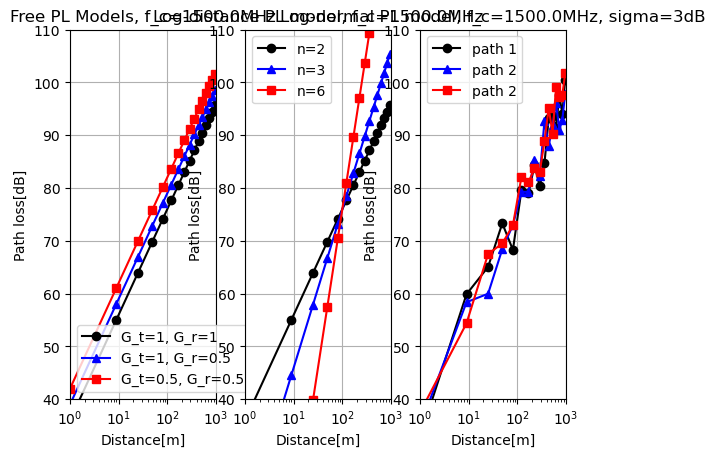

In [83]:
fc = 1.5e9
d0 = 100
sigma = 3
distance = np.array([i for i in range(1, 32, 2)]) ** 2
Gt = np.array([1, 1, 0.5])
Gr = np.array([1, 0.5, 0.5])
Exp = np.array([2, 3, 6])

y_Free = []
y_logdist = []
y_lognorm = []

for k in range(len(Gt)):
    y_Free.append(PL_free(fc, distance, Gt[k], Gr[k]))
    y_logdist.append(PL_logdist_or_norm(fc, distance, d0, Exp[k]))
    y_lognorm.append(PL_logdist_or_norm(fc, distance, d0, Exp[0], sigma))

plt.subplot(131)
plt.semilogx(distance, y_Free[0], 'k-o', distance, y_Free[1], 'b-^', distance, y_Free[2], 'r-s')
plt.grid(True)
plt.axis([1, 1000, 40, 110])
plt.title(f'Free PL Models, f_c={fc / 1e6}MHz')
plt.xlabel('Distance[m]')
plt.ylabel('Path loss[dB]')
plt.legend(['G_t=1, G_r=1', 'G_t=1, G_r=0.5', 'G_t=0.5, G_r=0.5'])

plt.subplot(132)
plt.semilogx(distance, y_logdist[0], 'k-o', distance, y_logdist[1], 'b-^', distance, y_logdist[2], 'r-s')
plt.grid(True)
plt.axis([1, 1000, 40, 110])
plt.title(f'Log-distance PL model, f_c={fc / 1e6}MHz')
plt.xlabel('Distance[m]')
plt.ylabel('Path loss[dB]')
plt.legend(['n=2', 'n=3', 'n=6'])

plt.subplot(133)
plt.semilogx(distance, y_lognorm[0], 'k-o', distance, y_lognorm[1], 'b-^', distance, y_lognorm[2], 'r-s')
plt.grid(True)
plt.axis([1, 1000, 40, 110])
plt.title(f'Log-normal PL model, f_c={fc / 1e6}MHz, sigma={sigma}dB')
plt.xlabel('Distance[m]')
plt.ylabel('Path loss[dB]')
plt.legend(['path 1', 'path 2', 'path 2'])

plt.show()

program 1.5 “PL_Hata” for Hata path loss model

In [121]:
def PL_Hata(fc, d, htx, hrx, Etype=None):
    """
    Hata Model

    :param fc: carrier frequency[Hz]
    :param d: between base station and mobile station[m]
    :param htx: height of transmitter[m]
    :param hrx: height of receiver[m]
    :param Etype: Environment Type('urban','suburban','open')
    :return:
    """

    if Etype is None:
        Etype = 'URBAN'

    fc = fc / 1e6
    if 150 <= fc <= 200:
        C_Rx = 8.29 * (np.log10(1.54 * hrx)) ** 2 - 1.1
    elif fc > 200:
        C_Rx = 3.2 * (np.log10(11.75 * hrx)) ** 2 - 4.97  # Eq.(1.9)
    else:
        C_Rx = 0.8 + (1.1 * np.log10(fc) - 0.7) * hrx - 1.56 * np.log10(fc)  # Eq.(1.8)

    PL = 69.55 + 26.16 * np.log10(fc) - 13.82 * np.log10(htx) - C_Rx \
         + (44.9 - 6.55 * np.log10(htx)) * np.log10(d / 1000)  # Eq.(1.7)

    EType = Etype.upper()
    if EType[0] == 'S':
        PL = PL - 2 * (np.log10(fc / 28)) ** 2 - 5.4  # Eq.(1.10)
    elif EType[0] == 'O':
        PL = PL + (18.33 - 4.78 * np.log10(fc)) * np.log10(fc) - 40.97  # Eq.(1.11)

    return PL


program 1.4 “plot_PL_Hata.m” to plot the Hata path loss model

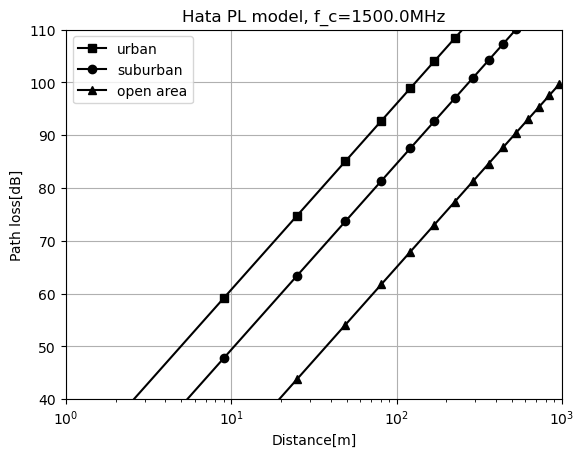

In [85]:
fc = 1.5e9
htx = 30
hrx = 2
distance = np.array([i for i in range(1, 32, 2)]) ** 2
y_urban = PL_Hata(fc, distance, htx, hrx, 'urban')
y_suburban = PL_Hata(fc, distance, htx, hrx, 'suburban')
y_open = PL_Hata(fc, distance, htx, hrx, 'open')

plt.semilogx(distance, y_urban, 'k-s', distance, y_suburban, 'k-o', distance, y_open, 'k-^')
plt.grid(True)
plt.axis([1, 1000, 40, 110])
plt.title(f'Hata PL model, f_c={fc / 1e6}MHz')
plt.xlabel('Distance[m]')
plt.ylabel('Path loss[dB]')
plt.legend(['urban', 'suburban', 'open area'])

plt.show()

program 1.6 “PL_IEEE80216d” for IEEE 802.16d path loss model

In [122]:
def PL_IEEE80216d(fc, d, type_1='A', htx=30, hrx=2, corr_fact='NO', mod='UNMOD'):
    """
    IEEE 802.16d model

    :param fc: carrier frequency
    :param d: between base and terminal
    :param type_1: selects 'A', 'B', or 'C'
    :param htx: height of transmitter
    :param hrx: height of receiver
    :param corr_fact: if shadowing exists, set to 'ATnT' or 'Okumura'. Otherwise, 'NO'
    :param mod: set to 'mod' to get the modified IEEE 802.16d model
    :return: path loss [dB]
    """
    Mod = mod.upper()

    d0 = 100
    Type = type_1.upper()
    if Type != 'A' and Type != 'B' and Type != 'C':
        print('Error: The selected type is not supported')
        return

    Corr_fact = corr_fact.upper()

    Cf = 0
    C_Rx = 0

    if Corr_fact == 'ATNT':
        Cf = 6 * np.log10(fc / 2e9)
        C_Rx = -10.8 * np.log10(hrx / 2)

    elif Corr_fact == 'OKUMURA':
        Cf = 6 * np.log10(fc / 2e9)
        if hrx <= 3:
            C_Rx = -10 * np.log10(hrx / 3)
        else:
            C_Rx = -20 * np.log10(hrx / 3)

    elif Corr_fact == 'NO':
        Cf = 0
        C_Rx = 0

    if Type == 'A':
        a = 4.6
        b = 0.0075
        c = 12.6
    elif Type == 'B':
        a = 4
        b = 0.0065
        c = 17.1
    else:
        a = 3.6
        b = 0.005
        c = 20

    lamda = 3e8 / fc
    gamma = a - b * htx + c / htx
    d0_pr = d0
    if Mod[0] == 'M':
        d0_pr = d0 * 10 ** -((Cf + C_Rx) / (10 * gamma))
    A = 20 * np.log10(4 * np.pi * d0_pr / lamda) + Cf + C_Rx

    PL = []

    for k in range(len(d)):
        if d[k] > d0_pr:
            PL.append(A + 10 * gamma * np.log10(d[k] / d0))
        else:
            PL.append(-10 * np.log10((lamda / (4 * np.pi * d[k])) ** 2))

    return PL

program 1.7 “plot_PL_IEEE80216d.m” to plot the IEEE 802.16d path loss model

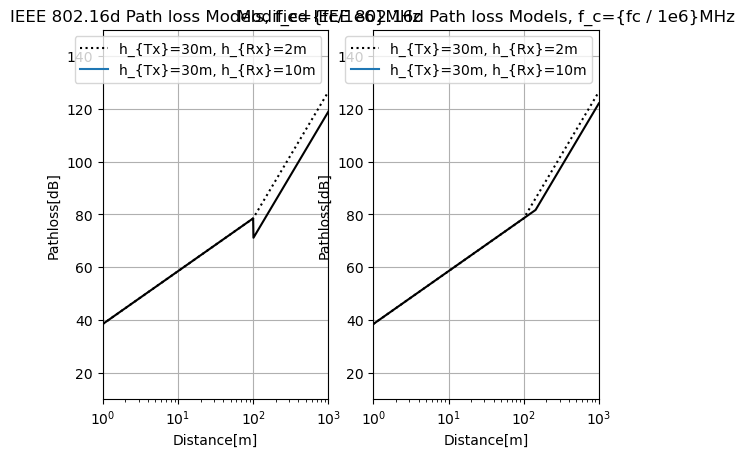

In [123]:
fc = 2e9
htx = [30, 30]
hrx = [2, 10]
distance = [i for i in range(1, 1001)]

y_IEEE16d = []
y_MIEEE16d = []

for k in range(len(htx)):
    y_IEEE16d.append(PL_IEEE80216d(fc, distance, 'A', htx[k], hrx[k], 'atnt'))
    y_MIEEE16d.append(PL_IEEE80216d(fc, distance, 'A', htx[k], hrx[k], 'atnt', 'mod'))

plt.subplot(121)
plt.semilogx(distance, y_IEEE16d[0], 'k:', 'linewidth', 1.5)
# hold on
plt.semilogx(distance, y_IEEE16d[1], 'k-', 'linewidth', 1.5)
plt.grid(True)
plt.title('IEEE 802.16d Path loss Models, f_c={fc/1e6}MHz')
plt.axis([1, 1000, 10, 150])
plt.xlabel('Distance[m]')
plt.ylabel('Pathloss[dB]')
plt.legend(['h_{Tx}=30m, h_{Rx}=2m', 'h_{Tx}=30m, h_{Rx}=10m'])

plt.subplot(122)
plt.semilogx(distance, y_MIEEE16d[0], 'k:', 'linewidth', 1.5)
# hold on
plt.semilogx(distance, y_MIEEE16d[1], 'k-', 'linewidth', 1.5)
plt.grid(True)
plt.title('Modified IEEE 802.16d Path loss Models, f_c={fc / 1e6}MHz')
plt.axis([1, 1000, 10, 150])
plt.xlabel('Distance[m]')
plt.ylabel('Pathloss[dB]')
plt.legend(['h_{Tx}=30m, h_{Rx}=2m', 'h_{Tx}=30m, h_{Rx}=10m'])

plt.show()

“Ray_model” for Rayleigh fading channel model program 1.9 

In [124]:
def Ray_model(L):
    """

    :param L: # of channel realization
    :return: Channel vector
    """
    H = (np.random.randn(L) + 1j * np.random.randn(L)) / np.sqrt(2)

    return H

 program 1.10 “Ric_model” for Rician fading channel model

In [125]:
def Ric_model(K_dB, L):
    """
    Rician Channel Model

    :param K_dB: K factor [dB]
    :param L: # of channel realization
    :return: channel vector
    """
    K = 10 ** (K_dB / 10)
    H = np.sqrt(K / (K + 1)) + np.sqrt(1 / (K + 1)) * Ray_model(L)

    return H

program 1.8 “plot_Ray_Ric_channel.m” to generate Rayleigh and Rician fading channels

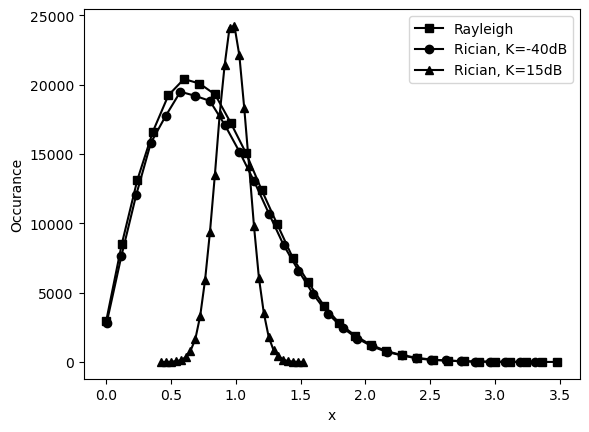

In [126]:
N = 200000
level = 30
K_dB = [-40, 15]
color = ['k']
line = ['-']
marker = ['s', 'o', '^']

# Rayleigh model
Rayleigh_ch = Ray_model(N)
temp, x = np.histogram(np.abs(Rayleigh_ch), level)
plt.plot(x[:-1], temp, f'k-{marker[0]}')

# Rician model
Rician_ch = []

for i in range(len(K_dB)):
    Rician_ch.append(Ric_model(K_dB[i], N))
    temp, x = np.histogram(np.abs(Rician_ch[i]), level)
    plt.plot(x[:-1], temp, f'k-{marker[i + 1]}')

plt.xlabel('x')
plt.ylabel('Occurance')
plt.legend(['Rayleigh', 'Rician, K=-40dB', 'Rician, K=15dB'])

plt.show()

# chapter 2

program 2.2 “exp_PDP” to generate an exponential PDP

In [127]:
def exp_PDP(tau_d, Ts, A_dB=-20, norm_flag=1):
    """
    Exponential PDP generator
    :param tau_d: rms delay spread in second
    :param Ts: Sampling time in second
    :param A_dB: the smallest noticeable power in dB
    :param norm_flag: normalizes total power to unit
    :return: PDP vector
    """
    sigma_tau = tau_d
    A = 10 ** (A_dB / 10)
    lmax = np.ceil(-tau_d * np.log(A) / Ts)  # get max. path index (2.8)/Ts
    # Computes normalization factor for power normalization
    if norm_flag:
        p0 = (1 - np.exp(-Ts / sigma_tau)) / (1 - np.exp(-(lmax + 1) * Ts / sigma_tau))  # (2.10)
    else:
        p0 = 1 / sigma_tau
    # Exponential PDP
    l = np.arange(0, lmax + 1)
    PDP = p0 * np.exp(-l * Ts / sigma_tau)  # (2.11)
    return PDP

 program 2.1  “plot_2ray_exp_model.m” to plot a 2-ray channel model and an exponential
model

C:\Users\sbida\anaconda3\lib\site-packages\numpy\ma\core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
C:\Users\sbida\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


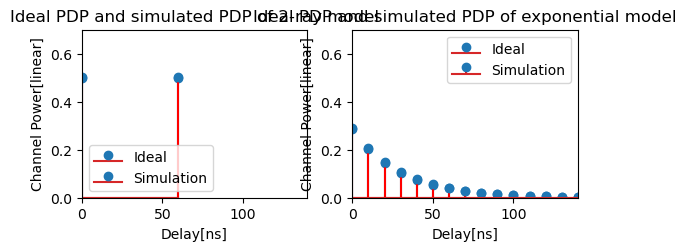

In [128]:
scale = 1e-9  # ns
Ts = 10 * scale  # Sampling time
t_rms = 30 * scale  # RMS delay spread
num_ch = 10000  # number of channels

# 2-ray model
pow_2 = [0.5, 0.5]
delay_2 = np.array([0, t_rms * 2]) / scale
H_2 = np.matrix(Ray_model(num_ch)).T @ np.matrix(np.sqrt(pow_2))
avg_pow_h_2 = np.mean(np.array(H_2) * np.array(np.conj(H_2)), axis=0)

plt.subplot(221)
plt.stem(delay_2, pow_2)
plt.stem(delay_2, avg_pow_h_2, linefmt='r.')
plt.xlabel('Delay[ns]')
plt.ylabel('Channel Power[linear]')
plt.title('Ideal PDP and simulated PDP of 2-ray model')
plt.legend(['Ideal', 'Simulation'])
plt.axis([0, 140, 0, 0.7])

# Exponential model
pow_e = exp_PDP(t_rms, Ts)
delay_e = np.arange(0, len(pow_e)) * Ts / scale
H_e = np.matrix(Ray_model(num_ch)).T @ np.matrix(np.sqrt(pow_e))
avg_pow_h_e = np.mean(np.array(H_e) * np.array(np.conj(H_e)), axis=0)

# TODO check that warning

plt.subplot(222)
plt.stem(delay_e, pow_e)
plt.stem(delay_e, avg_pow_h_e, linefmt='r.')
plt.xlabel('Delay[ns]')
plt.ylabel('Channel Power[linear]')
plt.title('Ideal PDP and simulated PDP of exponential model')
plt.legend(['Ideal', 'Simulation'])
plt.axis([0, 140, 0, 0.7])

plt.show()

program 2.4 “IEEE802_11_model” for IEEE 802.11 channel model

In [129]:
def IEEE802_11_model(sigma_tau, Ts):
    """
    IEEE 802.11 channel model PDP generator

    :param sigma_tau: RMS delay spread
    :param Ts: Sampling time
    :return: Power delay profile
    """
    lmax = np.ceil(10 * sigma_tau / Ts)  # (2.13)
    sigma02 = (1 - np.exp(-Ts / sigma_tau)) / (1 - np.exp(-(lmax + 1) * Ts / sigma_tau))  # (2.15)
    l = np.arange(0, lmax + 1)
    PDP = sigma02 * np.exp(-l * Ts / sigma_tau)  # (2.14)
    return PDP

 program 2.3 “plot_IEEE80211_model.m” to plot an IEEE 802.11 channel model

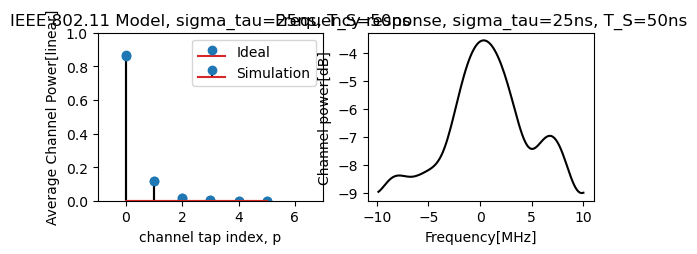

In [130]:
scale = 1e-9  # nano
Ts = 50 * scale  # Sampling time
t_rms = 25 * scale  # RMS delay spread
num_ch = 10000  # Number of channels
N = 128  # FFT size

h = []
avg_pow_h = []

PDP = IEEE802_11_model(t_rms, Ts)

for k in range(0, len(PDP)):
    r1 = np.matrix(Ray_model(num_ch)).T * np.matrix(np.sqrt(PDP[k]))
    r1 = np.array(r1)
    h.append(r1)
    avg_pow_h.append(np.mean(h[k] * np.conj(h[k]), axis=0))

h1 = np.array(h)

# TODO check h1[:, 0, 0]
H = np.fft.fft(h1[:, 0, 0], N)

plt.subplot(221)
plt.stem(np.arange(0, len(PDP)), PDP, linefmt='ko')
plt.stem(np.arange(0, len(PDP)), avg_pow_h, linefmt='k.')
plt.xlabel('channel tap index, p')
plt.ylabel('Average Channel Power[linear]')
plt.title('IEEE 802.11 Model, sigma_tau=25ns, T_S=50ns')
plt.legend(['Ideal', 'Simulation'])
plt.axis([-1, 7, 0, 1])

plt.subplot(222)
plt.plot(np.arange(-N / 2 + 1, N / 2 + 1) / N / Ts / 10 ** 6, 10 * np.log10(H * np.conj(H)), 'k-')
plt.xlabel('Frequency[MHz]')
plt.ylabel('Channel power[dB]')
plt.title('Frequency response, sigma_tau=25ns, T_S=50ns')

plt.show()

program 2.6 “SV_model_ct” for Saleh-Valenzuela channel

In [131]:
def SV_model_ct(Lam, lam, Gam, gam, num_ch, b002=1, sdi=0, nlos=0):
    """
    S-V channel model

    :param Lam: Cluster arrival rate in GHz (avg # of clusters per nsec)
    :param lam: Ray arrival rate in GHz (avg # of rays per nsec)
    :param Gam: Cluster decay factor (time constant, nsec)
    :param gam: Ray decay factor (time constant, nsec)
    :param num_ch: number of random realizations to generate
    :param b002: power of first ray of first cluster
    :param sdi: Standard deviation of log-normal shadowing of entire impulse  response [dB]
    :param nlos: Flag to specify generation of Non Line Of Sight channels
    :return:
        - h - a matrix with num_ch columns, each column having a random realization of channel model (impulse response)
        - t - organized as h, but holds the time instances (in nsec) of the paths whose signed amplitudes are stored in h
        - t0 - the arrival time of the first cluster for each realization
        - np_1 - the number of paths for each realization.
    """
    h_len = 1000

    t0 = []
    np_1 = []

    h = []
    t = []

    # TODO check exprnd is same as exponential
    for k in range(num_ch):  # loop over number of channels
        tmp_h = np.zeros(h_len)
        tmp_t = np.zeros(h_len)
        if nlos:
            Tc = np.exponential(1 / Lam)  # First cluster random arrival ???
        else:
            Tc = 0  # First cluster arrival occurs at time 0

        t0.append(Tc)
        path_ix = 0
        while Tc < 10 * Gam:  # cluster loop
            # Determine Ray arrivals for each cluster
            Tr = 0  # 1st ray arrival defined to be time 0 relative to cluster
            while Tr < 10 * gam:  # ray loop
                brm2 = b002 * np.exp(-Tc / Gam) * np.exp(-Tr / gam)  # ray power (2.20)
                r = np.sqrt(np.random.randn() ** 2 + np.random.randn() ** 2) * np.sqrt(brm2 / 2)
                # rayleigh distributed mean power pow_bkl
                h_val = np.exp(1j * 2 * np.pi * np.random.rand()) * r  # uniform phase
                tmp_h[path_ix] = h_val
                tmp_t[path_ix] = Tc + Tr  # time of arrival of this ray
                path_ix = path_ix + 1  # row index of this ray
                Tr = Tr + np.random.exponential(1 / Lam)  # Eq.(2.11)

            Tc = Tc + np.random.exponential(1 / lam)  # Eq.(2.10)

        np_1.append(path_ix)  # number of rays (or paths) for this realization
        sort_tmp_t = np.sort(tmp_t[:np_1[k]])  # in ascending order
        sort_ix = np.argsort(tmp_t[:np_1[k]])
        t.append(sort_tmp_t)
        h.append(tmp_h[sort_ix[:np_1[k]]])
        # now impose a log-normal shadowing on this realization
        fac = 10 ** (sdi * np.random.randn() / 20) / np.sqrt(h[k].T @ h[k])
        h[k] = h[k] * fac  # Eq.(2.15)

    return h, t, t0, np_1

program 2.5 “plot_SV_model_ct.m” to plot a Saleh-Valenzuela channel model

C:\Users\sbida\AppData\Local\Temp\ipykernel_17360\1084990550.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  tmp_h[path_ix] = h_val


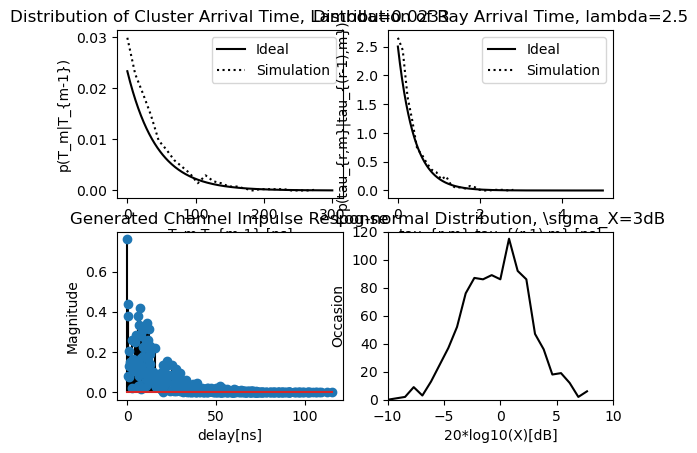

In [132]:
b002 = 1  # Power of 1st ray of 1st cluster
N = 1000  # Number of channels
Lam = 0.0233
lambda_1 = 2.5
Gam = 7.4
gamma = 4.3
sigma_x = 3  # Standard deviation of log-normal shadowing

plt.subplot(221)
t1 = np.arange(0, 301)
p_cluster = Lam * np.exp(-Lam * t1)  # ideal exponential pdf
h_cluster = np.random.exponential(1 / Lam, [1, N])  # # of random number are generated
n_cluster, x_cluster = np.histogram(h_cluster, 25)  # gets distribution
plt.plot(t1, p_cluster, 'k')
plt.plot(x_cluster[:-1], n_cluster * p_cluster[1] / n_cluster[1], 'k:')  # plotting
plt.legend(['Ideal', 'Simulation'])
plt.title(f'Distribution of Cluster Arrival Time, Lambda={Lam}')
plt.xlabel('T_m-T_{m-1} [ns]')
plt.ylabel('p(T_m|T_{m-1})')

# TODO fix latex formatting
plt.subplot(222)
t2 = np.arange(0, 5, 0.01)
p_ray = lambda_1 * np.exp(-lambda_1 * t2)  # ideal exponential pdf
h_ray = np.random.exponential(1 / lambda_1, [1, 1000])  # number of random number are generated
n_ray, x_ray = np.histogram(h_ray, 25)  # gets distribution
plt.plot(t2, p_ray, 'k')
plt.plot(x_ray[:-1], n_ray * p_ray[1] / n_ray[1], 'k:')  # plotting graph
plt.legend(['Ideal', 'Simulation'])
plt.title(f'Distribution of Ray Arrival Time, lambda={lambda_1}')
plt.xlabel('tau_{r,m}-tau_{(r-1),m} [ns]')
plt.ylabel('p(tau_{r,m}|tau_{(r-1),m})')

plt.subplot(223)
[h, t, t0, np_1] = SV_model_ct(Lam, lambda_1, Gam, gamma, N, b002, sigma_x)
# h and t are different in terms of dimensions, compare to source code
plt.stem(t[0][:np_1[0]], np.abs(h[0][:np_1[0]]), linefmt='ko')
plt.title('Generated Channel Impulse Response')
plt.xlabel('delay[ns]')
plt.ylabel('Magnitude')

plt.subplot(224)
X = 10 ** (sigma_x * np.random.randn(1, N) / 20)
temp, x = np.histogram(20 * np.log10(X), 25)
plt.plot(x[:-1], temp, 'k-')
plt.axis([-10, 10, 0, 120])
plt.title(f'Log-normal Distribution, \sigma_X={sigma_x}dB')
plt.xlabel('20*log10(X)[dB]')
plt.ylabel('Occasion')

plt.show()

 program 2.8 “UWB_parameters” to set the parameters for UWB channel model

In [133]:
def UWB_parameters(cm):
    """
    S-V model parameters for standard UWB channel models
    :param cm:
        =1: based on TDC measurements for LOS 0-4m,
        =2: based on TDC measurements for NLOS 0-4m,
        =3 : based on TDC measurements for NLOS 4-10m,
        =4 : 25 nsec RMS delay spread bad multipath channel
    :return:
        -   Lam  : Cluster arrival rate (clusters per nsec)
        -   lam  : Ray arrival rate (rays per nsec)
        -   Gam  : Cluster decay factor (time constant, nsec)
        -   gam  : Ray decay factor (time constant, nsec)
        -   nlos : Flag for non line of sight channel
        -   sdi  : Standard deviation of log-normal shadowing of entire impulse response
        -   sdc  : Standard deviation of log-normal variable for cluster fading
        -   sdr  : Standard deviation of log-normal variable for ray fading
    """
    # Table 2.1:
    tmp = 4.8 / np.sqrt(2)
    Tb2_1 = np.array([[0.0233, 2.5, 7.1, 4.3, 0, 3, tmp, tmp],
                      [0.4, 0.5, 5.5, 6.7, 1, 3, tmp, tmp],
                      [0.0667, 2.1, 14.0, 7.9, 1, 3, tmp, tmp],
                      [0.0667, 2.1, 24, 12, 1, 3, tmp, tmp]])

    cm -= 1

    Lam = Tb2_1[cm, 0]
    lam = Tb2_1[cm, 1]
    Gam = Tb2_1[cm, 2]
    gam = Tb2_1[cm, 3]
    nlos = Tb2_1[cm, 4]
    sdi = Tb2_1[cm, 5]
    sdc = Tb2_1[cm, 6]
    sdr = Tb2_1[cm, 7]

    return Lam, lam, Gam, gam, nlos, sdi, sdc, sdr

 program 2.9 “convert_UWB_ct” to convert a continuous-time channel into a discrete-time one

In [134]:
def convert_UWB_ct(h_ct, t, np_1, num_channels, ts):
    """
    convert continuous-time channel model h_ct to N-times oversampled discrete-time samples
    :param h_ct: a matrix with num_ch columns, each column having a random realization
         of the channel model (impulse response)
    :param t: organized as h, but holds the time instances (in nsec) of the paths
        whose signed amplitudes are stored in h
    :param np_1: the number of paths for each realization.
    :param num_channels: number of random realizations to generate
    :param ts: desired time resolution
    :return:
        - hN: will be produced with time resolution ts / N
    """
    min_Nfs = 100  # GHz
    N = np.max([1., np.ceil(min_Nfs * ts)])
    N = 2 ** np.ceil(np.log2(N))  # make N a power of 2 to facilitate efficient multi-stage decimation

    # NOTE: if we force N = 1 and ts = 0.167, the resulting channel hN will be identical to
    # the results from earlier versions that did not use continuous-time.
    Nfs = N / ts
    k1 = [np.max(x) for x in t]
    t_max = np.max(k1)  # maximum time value across all channels
    h_len = int(1 + np.floor(t_max * Nfs))  # number of time samples at resolution ts / N

    hN = np.zeros([h_len, num_channels])

    for k in range(num_channels):
        np_k = np_1[k]  # number of paths in this channel
        # TODO check np_k + 1
        # TODO check h_ct and t which I changed
        t_Nfs = np.floor(t[k][:np_k] * Nfs)  # vector of quantized time indices for this channel
        for n in range(0, np_k):
            hN[int(t_Nfs[n]), k] = hN[int(t_Nfs[n]), k] + h_ct[n,k]

    return hN, N

program 2.10 “UWB_model_ct” for a continuous-time UWB channel model

In [135]:
def UWB_model_ct(Lam, lam, Gam, gam, num_ch, nlos, sdi, sdc, sdr):
    """
    IEEE 802.15.3a UWB channel model for PHY proposal evaluation continuous-time realization of modified S-V channel model
    :param Lam: Cluster arrival rate in GHz (avg # of clusters per nsec)
    :param lam: Ray arrival rate in GHz (avg # of rays per nsec)
    :param Gam: Cluster decay factor (time constant, nsec)
    :param gam: Ray decay factor (time constant, nsec)
    :param num_ch: number of random realizations to generate
    :param nlos: Flag to specify generation of Non Line Of Sight channels
    :param sdi: Standard deviation of log-normal shadowing of entire impulse response
    :param sdc: Standard deviation of log-normal variable for cluster fading
    :param sdr: Standard deviation of log-normal variable for ray fading
    :return:
        h     : a matrix with num_ch columns, each column having a random realization
         of the channel model (impulse response)
        t     : organized as h, but holds the time instances (in nsec) of the paths
        whose signed amplitudes are stored in h
        t0    : the arrival time of the first cluster for each realization
        np_1    : the number of paths for each realization.
    """
    # Initialize and precompute some things
    sd_L = 1 / np.sqrt(2 * Lam)  # std dev (nsec) of cluster arrival spacing
    sd_l = 1 / np.sqrt(2 * lam)  # std dev (nsec) of ray arrival spacing
    mu_const = (sdc ** 2 + sdr ** 2) * np.log(10) / 20  # pre-compute for later
    h_len = 1000  # there must be a better estimate of # of paths than this

    t0 = []
    np_1 = []

    h = []
    t = []

    for k in range(num_ch):  # loop over number of channels
        tmp_h = np.zeros(h_len)
        tmp_t = np.zeros(h_len)
        if nlos:
            Tc = (sd_L * np.random.randn()) ** 2 + (sd_L * np.random.randn()) ** 2  # First cluster random arrival
        else:
            Tc = 0  # First cluster arrival occurs at time 0

        t0.append(Tc)
        path_ix = 0
        while Tc < 10 * Gam:
            # Determine Ray arrivals for each cluster
            Tr = 0  # first ray arrival defined to be time 0 relative to cluster
            ln_xi = sdc * np.random.randn()  # set cluster fading (new line added in rev. 1)
            while Tr < 10 * gam:
                t_val = Tc + Tr  # time of arrival of this ray
                mu = (-10 * Tc / Gam - 10 * Tr / gam) / np.log(10) - mu_const  # (2.25) ???
                ln_beta = mu + sdr * np.random.randn()
                pk = 2 * np.round(np.random.rand()) - 1
                h_val = pk * 10 ** ((ln_xi + ln_beta) / 20)  # (2.23) signed amplitude of this ray
                # row index of this ray
                tmp_h[path_ix] = h_val
                tmp_t[path_ix] = t_val
                path_ix = path_ix + 1
                Tr = Tr + (sd_l * np.random.randn()) ** 2 + (sd_l * np.random.randn()) ** 2
            Tc = Tc + (sd_L * np.random.randn()) ** 2 + (sd_L * np.random.randn()) ** 2

        np_1.append(path_ix)  # number of rays (or paths) for this realization
        sort_tmp_t = np.sort(tmp_t[:np_1[k]])  # in ascending order
        sort_ix = np.argsort(tmp_t[:np_1[k]])
        t.append(sort_tmp_t)
        h.append(tmp_h[sort_ix[:np_1[k]]])
        # now impose a log-normal shadowing on this realization
        fac = 10 ** (sdi * np.random.randn() / 20) / np.sqrt(h[k].T @ h[k])
        h[k] = h[k] * fac  # Eq.(2.15)

    m_h = len(max(h, key=len))

    h1 = np.array([list(i) + [0] * (m_h - len(list(i))) for i in h]).T

    # for i in range(len(h)):
    #     if

    return h1, t, t0, np_1

program 2.7 “plot_UWB_channel.m” to plot a UWB channel model

Model Parameters
Lam= 0.0233, lam= 2.5000, Gam= 7.1000, gam= 4.3000
 NLOS flag= 0.0, std_shdw= 3.0000, std_ln_1= 3.3941, std_ln_2= 3.3941

Model Characteristics
Mean delays: excess (tau_m) = 6.1 ns, RMS (tau_rms) = 9.1
# paths: NP_10dB =  14.0, NP_85%% = 23.7
Channel energy: mean = 0.2 dB, std deviation = 3.0 dB


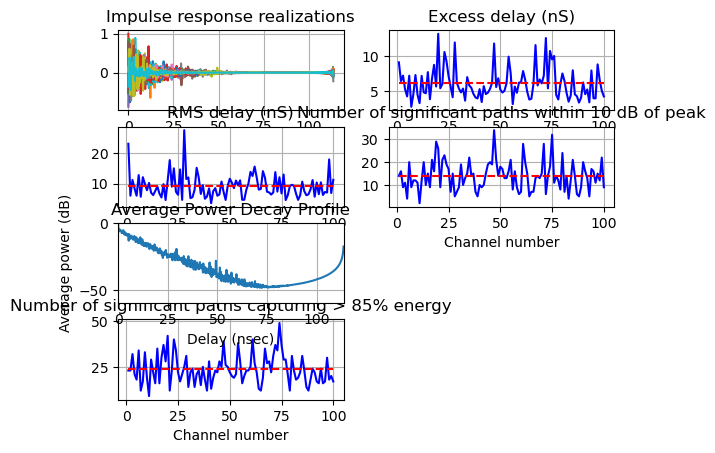

In [136]:
no_output_files = 0  # non-zero: avoids writing output files of continuous-time responses
Ts = 0.167  # sampling time (nsec)
num_ch = 100  # number of channel impulse responses to generate

# TODO test state
# TODO Complete it

np.random.seed(12)
cm = 1  # channel model number from 1 to 4
# get channel model params based on this channel model number
[Lam, lam, Gam, gam, nlos, sdi, sdc, sdr] = UWB_parameters(cm)
print(f'Model Parameters\nLam= {Lam:.4f}, lam= {lam:.4f}, Gam= {Gam:.4f}'
      f', gam= {gam:.4f}\n NLOS flag= {nlos}'
      f', std_shdw= {sdi:.4f}, std_ln_1= {sdc:.4f}, std_ln_2= {sdr:.4f}\n')

# get a bunch of realizations (impulse responses)
[h_ct, t_ct, t0, np_1] = UWB_model_ct(Lam, lam, Gam, gam, num_ch, nlos, sdi, sdc, sdr)
# now reduce continuous-time result to a discrete-time result
[hN, N] = convert_UWB_ct(h_ct, t_ct, np_1, num_ch, Ts)
# if we wanted complex baseband model or to impose some filtering function,
# this would be a good place to do it

# TODO check resample with scipy which doesn't match exactly with matlab version
h = sg.resample(hN, int(len(hN) / N))  # decimate the columns of hN by factor N
h = h * N  # correct for 1/N scaling imposed by decimation
channel_energy = np.sum(np.abs(h) ** 2, axis=0)  # channel energy
h_len = h.shape[0]
t = np.arange(h_len) * Ts  # for use in computing excess & RMS delays

excess_delay = []
rms_delay = []
num_sig_paths = []
num_sig_e_paths = []

for k in range(num_ch):
    # determine excess delay and RMS delay
    sq_h = np.abs(h[:, k]) ** 2 / channel_energy[k]
    t_norm = t - t0[k]  # remove the randomized arrival time of first cluster
    excess_delay.append(t_norm @ sq_h)
    rms_delay.append(
        np.sqrt(((t_norm - excess_delay[k]) ** 2) @ sq_h)
    )
    # determine # of significant paths (paths within 10 dB from peak)
    threshold_dB = -10  # dB
    temp_h = np.abs(h[:, k])
    temp_thresh = 10 ** (threshold_dB / 20) * np.max(temp_h)
    num_sig_paths.append(np.sum(temp_h > temp_thresh))
    # determine number of sig. paths (captures x % of energy in channel)
    x = 0.85
    temp_sort = np.sort(temp_h ** 2)  # sorted in ascending order of energy
    cum_energy = np.cumsum(temp_sort[::-1])  # cumulative energy
    index_e = np.min(np.nonzero(cum_energy >= x * cum_energy[-1]))
    num_sig_e_paths.append(index_e)

energy_mean = np.mean(10 * np.log10(channel_energy))
energy_stddev = np.std(10 * np.log10(channel_energy))
mean_excess_delay = np.mean(excess_delay)
mean_rms_delay = np.mean(rms_delay)
mean_sig_paths = np.mean(num_sig_paths)
mean_sig_e_paths = np.mean(num_sig_e_paths)

print('Model Characteristics')
print(f'Mean delays: excess (tau_m) = {mean_excess_delay:.1f} ns, RMS (tau_rms) = {mean_rms_delay:.1f}')
print(f'# paths: NP_10dB =  {mean_sig_paths:.1f}, NP_85%% = {mean_sig_e_paths:.1f}')
print(f'Channel energy: mean = {energy_mean:.1f} dB, std deviation = {energy_stddev:.1f} dB')

plt.subplot(421)
plt.plot(t, h)
plt.grid(True)
plt.title('Impulse response realizations')
plt.xlabel('Time (nS)')

plt.subplot(422)
plt.plot(np.arange(1, num_ch + 1), excess_delay, 'b-', [1, num_ch], mean_excess_delay * np.array([1, 1]), 'r--')
plt.grid(True)
plt.title('Excess delay (nS)')
plt.xlabel('Channel number')

plt.subplot(423)
plt.plot(np.arange(1, num_ch + 1), rms_delay, 'b-', [1, num_ch], mean_rms_delay * np.array([1, 1]), 'r--')
plt.grid(True)
plt.title('RMS delay (nS)')
plt.xlabel('Channel number')
#
plt.subplot(424)
plt.plot(np.arange(1, num_ch + 1), num_sig_paths, 'b-', [1, num_ch], mean_sig_paths * np.array([1, 1]), 'r--')
plt.grid(True)
plt.title('Number of significant paths within 10 dB of peak')
plt.xlabel('Channel number')
#
plt.subplot(427)
plt.plot(np.arange(1, num_ch + 1), num_sig_e_paths, 'b-', [1, num_ch], mean_sig_e_paths * np.array([1, 1]), 'r--')
plt.grid(True)
plt.title('Number of significant paths capturing > 85% energy')
plt.xlabel('Channel number')

# TODO check h.T
temp_average_power = np.sum(h * h, axis=1) / num_ch
temp_average_power = temp_average_power / np.max(temp_average_power, axis=0)
average_decay_profile_dB = 10 * np.log10(temp_average_power)
plt.subplot(425)
plt.plot(t, average_decay_profile_dB)
plt.grid(True)
plt.axis([0, t[-1], -60, 0])
plt.title('Average Power Decay Profile')
plt.xlabel('Delay (nsec)')
plt.ylabel('Average power (dB)')

plt.show()

program 2.12 “FWGN_model”

In [137]:
def FWGN_model(fm, fs, N):
    # Make them simple by taking a FFT with some 2^n points.
    # tone spacing df=2fm/Nfft
    z1 = int(np.ceil(np.log2(2 * fm / fs * N)))
    Nfft = 2 ** max(3, z1)  # Nfft=2^n
    Nifft = np.ceil(Nfft * fs / (2 * fm))

    # Generate the inependent complex gaussian random process.
    GI = np.random.randn(Nfft)
    GQ = np.random.randn(Nfft)
    # take FFT of real signal in order to make hermitian symmetric
    CGI = np.fft.fft(GI)
    CGQ = np.fft.fft(GQ)
    # Nfft sample Doppler spectrum generation
    doppler_coeff = Doppler_spectrum(fm, Nfft)

    # Do the filtering of the gaussian random variables here.
    f_CGI = CGI * np.sqrt(doppler_coeff)
    f_CGQ = CGQ * np.sqrt(doppler_coeff)

    # adjusting sample size to take IFFT by (Nifft-Nfft) sample zero-padding
    tzeros = np.zeros(int(Nifft - Nfft))
    Filtered_CGI = np.concatenate([f_CGI[:Nfft // 2 + 1], tzeros, f_CGI[Nfft // 2 + 1: Nfft]])
    Filtered_CGQ = np.concatenate([f_CGQ[:Nfft // 2 + 1], tzeros, f_CGQ[Nfft // 2 + 1: Nfft]])
    hI = np.fft.ifft(Filtered_CGI)
    hQ = np.fft.ifft(Filtered_CGQ)

    # Take the magnitude squared of the I and Q components and add them together.
    rayEnvelope = np.sqrt(np.abs(hI) ** 2 + np.abs(hQ) ** 2)
    # Compute the Root Mean Squared Value and Normalize the envelope.

    N = int(N)

    rayRMS = np.sqrt(np.mean(rayEnvelope[:N] * rayEnvelope[:N]))
    h = np.real(hI[:N]) - 1j * np.real(hQ[:N]) / rayRMS

    return h, Nfft, Nifft, doppler_coeff

 program 2.13 “Doppler_spectrum”

In [138]:
def Doppler_spectrum(fd, Nfft):
    """

    :param fd: maximum Doppler frequency
    :param Nfft: number of frequency domain points
    :return:
    """
    df = 2 * fd / Nfft  # Frequency Spacing.

    Nfft_2 = Nfft // 2

    f = np.zeros(Nfft_2)
    y = np.zeros(Nfft)

    # The DC component first.
    f[0] = 0
    y[0] = 1.5 / (np.pi * fd)
    # The other components for ONE side the spectrum.
    for i in range(1, Nfft // 2):
        f[i] = (i * df)  # The frequency indices for polynomial fitting.
        k1 = 1.5 / (np.pi * fd * np.sqrt(1 - (f[i] / fd) ** 2))
        y[i] = k1
        y[Nfft - i] = k1

    # nyquist frequency applied polynomial fitting using the last 3 frequency samples.
    nFitPoints = 3
    # kk = np.arange(Nfft / 2 - nFitPoints, (Nfft / 2) + 1)

    # TODO check Nfft_2 - nFitPoints - 1
    polyFreq = np.polyfit(f[Nfft_2 - nFitPoints - 1:Nfft_2],
                          y[Nfft_2 - nFitPoints - 1:Nfft_2],
                          nFitPoints)

    y[Nfft_2] = np.polyval(polyFreq, f[Nfft_2 - 1] + df)

    return y

program 2.11  “plot_FWGN.m” to plot an FWGN model

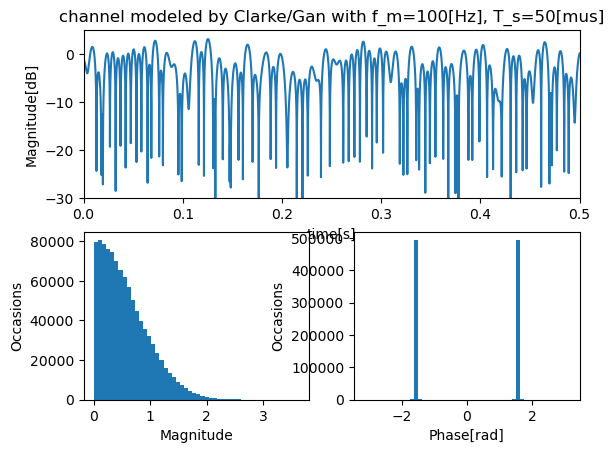

In [139]:
fm = 100  # Maximum Doppler frquency
ts_mu = 50
scale = 1e-6
ts = ts_mu * scale  # Sampling time
fs = 1 / ts  # Sampling frequency
Nd = 1e6  # Number of samples
# To get the complex fading channel
h, Nfft, Nifft, doppler_coeff = FWGN_model(fm, fs, Nd)

plt.subplot(211)
plt.plot(np.arange(1, Nd + 1) * ts, 10 * np.log10(np.abs(h)))
plt.axis([0, 0.5, -30, 5])
str_2 = f'channel modeled by Clarke/Gan with f_m={fm}[Hz], T_s={ts_mu}[mus]'
plt.title(str_2)
plt.xlabel('time[s]')
plt.ylabel('Magnitude[dB]')

plt.subplot(223)
plt.hist(np.abs(h), 50)
plt.xlabel('Magnitude')
plt.ylabel('Occasions')

plt.subplot(224)
plt.hist(np.angle(h), 50)
plt.xlabel('Phase[rad]')
plt.ylabel('Occasions')

plt.show()


program 2.16 “Doppler_PSD_function” for Doppler spectrum function

In [152]:
def Doppler_PSD_function(type):
    def fl(f0):
        return np.ones(1, len(f0))

    def cl(f0):
        return 1. / np.sqrt(1 + 1e-9 - f0 ** 2)

    def la(f0, sigma, phi):
        return (np.exp(-np.sqrt(2) / sigma * np.abs(np.acos(f0) - phi)) + np.exp(
            -np.sqrt(2) / sigma * np.abs(np.acos(f0) + phi))) / np.sqrt(1 + 1e-9 - f0 ** 2)

    def su(f0):
        return 0.785 * f0 ** 4 - 1.72 * f0 ** 2 + 1.

    def r_3g(f, fm):
        # TODO ask about delta_ftn
        # return 0.41/(2*np.pi*fm*np.sqrt(1+1e-9-(f/fm)**2))+0.91*delta_ftn(f,0.7*fm)
        return 0.41 / (2 * np.pi * fm * np.sqrt(1 + 1e-9 - (f / fm) ** 2)) + 0.91 * (f * 0.7 * fm)

    def dr(f, Dsp, Dsh):
        return (1. / np.sqrt(2 * np.pi * Dsp / 2)) * np.exp(-(f - Dsh) ** 2 / Dsp)

    d = {
        'fl': fl,
        'cl': cl,
        'la': la,
        'su': su,
        '3g': r_3g,
        'dr': dr
    }

    t1 = type[:2].lower()

    if t1 in d:
        return d[t1]
    else:
        return None

program 2.15 “FWGN_ff” for a modfied frequency-domain FWGN channel

In [153]:
def FWGN_ff(Np, fm_Hz, Nfading, Nfosf, FadingType, varargin):
    fmax = np.max(fm_Hz)
    dfmax = 2 * Nfosf * fmax / Nfading
    if np.isscalar(fm_Hz):
        # (1, Np) -> (Np)
        fm_Hz = fm_Hz * np.ones(Np)

    # To get a funtion corresponding to Doppler spectrum of "FadingType"
    FadingType = FadingType.lower()
    ftn_psd = Doppler_PSD_function(FadingType)

    FadFreq = []

    if FadingType[: 2] == 'la':  # Laplacian constrained PAS
        for i in range(Np):
            Nd = np.floor(fm_Hz[i] / dfmax) - 1
            if Nd < 1:
                return
            tmp = ftn_psd(np.arange(-Nd, Nd + 1), varargin[1][i], varargin[2][i])
            tmpz = np.zeros(Nfading - 2 * Nd + 1)
            FadFreq.append(np.concatenate([tmp[int(Nd):-1], tmpz, tmp[1:int(Nd)]]))
    else:
        for i in range(Np):
            Nd = np.floor(fm_Hz[i] / dfmax) - 1
            if Nd < 1:
                return
            tmp = ftn_psd(np.arange(0, Nd + 1) / Nd)
            # TODO check one dimension
            tmpz = np.zeros(int(Nfading - 2 * Nd + 3))
            # TODO check fliplr
            FadFreq.append(np.concatenate([tmp[: int(Nd) - 1], tmpz, tmp[1:int(Nd) - 1][::-1]]))

    # Add a random phase to the Doppler spectrum
    FadFreq = np.sqrt(FadFreq) * np.exp(2 * np.pi * 1j * np.random.rand(Np, Nfading))
    # TODO check fourier axis
    FadTime = np.fft.ifft(FadFreq, Nfading, 1)
    tf = 1 / (2 * fmax * Nfosf)  # fading sample time=1/(Doppler BW*Nfosf)

    return FadTime, tf

program 2.18 “gen_filter” for Doppler filter coefficients

In [154]:
def gen_filter(fm_Hz, fmax_Hz, Nfading, Nfosf, type, varargin):
    # Doppler BW= 2*fm*Nfosf ==> 2*fmax_Hz*Nfosf
    dfmax = 2 * Nfosf * fmax_Hz / Nfading  # Doppler frequency spacing
    # respect to maximal Doppler frequency
    Nd = np.floor(fm_Hz / dfmax) - 1  #
    if Nd < 1:
        return

    ftn_PSD = Doppler_PSD_function(type)

    t1 = type[:2].lower()

    if t1 == '3g':
        PSD = ftn_PSD(np.arange(-Nd, Nd + 1), Nd)
        filt = np.concatenate([PSD[Nd:-1], np.zeros(int(Nfading - 2 * Nd + 1), float), PSD[1:]])
    elif t1 == 'la':
        PSD = ftn_PSD(np.arange(-Nd, Nd + 1) / Nd, varargin)
        filt = np.concatenate([PSD[Nd:-1], np.zeros(int(Nfading - 2 * Nd + 1), float), PSD[1: Nd]])
    else:
        PSD = ftn_PSD(np.arange(0, Nd + 1) / Nd)
        filt = np.concatenate([PSD[:-1], np.zeros(int(Nfading - 2 * Nd + 3), float), PSD[-2:0:-1]])
        # constructs a symmetric Doppler spectrum

    filt = np.real(np.fft.ifftshift(np.fft.ifft(np.sqrt(filt))))
    filt = filt / np.sqrt(np.sum(filt ** 2))

    return filt

program 2.17 “FWGN_tf” for time-domain FWGN channel

In [155]:
def FWGN_tf(Np, fm_Hz, N, M, Nfosf, type, varargin):
    if np.isscalar(fm_Hz):
        fm_Hz = fm_Hz * np.ones(Np)

    fmax = np.max(fm_Hz)
    # TODO test 1j instead of complex
    path_wgn = np.sqrt(1 / 2) * (np.random.randn(Np, N) + 1j * np.random.randn(Np, N))

    path = []

    for p in range(Np):
        filt = gen_filter(fm_Hz[p], fmax, M, Nfosf, type, varargin)
        # TODO test signal.filtfilt
        # b, a = sg.butter(len(filt), filt)
        # path.append(sg.filtfilt(b, a, np.concatenate([path_wgn[p, :], np.zeros(M)])))  # filtering WGN

        path.append(sg.convolve(filt, np.concatenate([path_wgn[p, :], np.zeros(M)]), 'full', 'direct')[
                    :len(filt)])  # filtering WGN

    path = np.array(path)

    FadMtx = path[:, M / 2:- M / 2]
    tf = 1 / (2 * fmax * Nfosf)  # fading sample time=1/(Max. Doppler BW*Nfosf)
    # Normalization to 1
    # TODO test FadMtx.shape[1]
    FadMtx = FadMtx / np.sqrt(np.mean(np.abs(FadMtx) ** 2, 2) * np.ones(1, FadMtx.shape[1]))

    return FadMtx, tf

program 2.14 “plot_modified_FWGN.m” to plot modified FWGN channel models

#### need some works

TypeError: slice indices must be integers or None or have an __index__ method

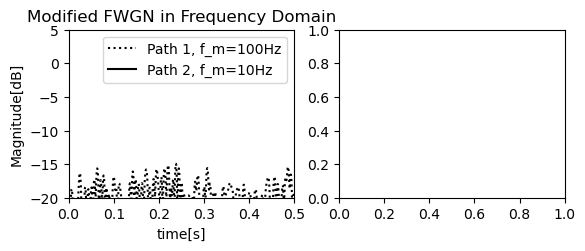

In [156]:



Nfading = 1024  # IFFT size for the Npath x Nfading fading matrix
Nos = 8  # Fading oversampling factor
Npath = 2  # Number of paths
N = 10000
FadingType = 'class'
fm = [100, 10]  # Doppler frequency

plt.subplot(221)
FadingMatrix, tf = FWGN_ff(Npath, fm, Nfading, Nos, FadingType, None)
plt.plot(np.arange(1, Nfading + 1) * tf, 10 * np.log10(np.abs(FadingMatrix[0, :])), 'k:')
plt.plot(np.arange(1, Nfading + 1) * tf, 10 * np.log10(np.abs(FadingMatrix[1, :])), 'k-')
plt.title('Modified FWGN in Frequency Domain')
plt.xlabel('time[s]')
plt.ylabel('Magnitude[dB]')
# set(gca,'fontsize',9)
plt.legend(['Path 1, f_m=100Hz', 'Path 2, f_m=10Hz'])
plt.axis([0, 0.5, -20, 5])

plt.subplot(222)
# TODO change varargin to args
[FadingMatrix, tf] = FWGN_tf(Npath, fm, N, Nfading, Nos, FadingType, None)
plt.plot(np.arange(1, N + 1) * tf, 10 * np.log10(np.abs(FadingMatrix[1, :])), 'k:')

plt.plot(np.arange(1, N + 1) * tf, 10 * np.log10(np.abs(FadingMatrix[2, :])), 'k-')
plt.title('Modified FWGN in Time Domain')

plt.xlabel('time[s]')
plt.ylabel('Magnitude[dB]')
# set(gca, 'fontsize', 9)
plt.legend(['Path 1, f_m=100Hz', 'Path 2, f_m=10Hz'])
plt.axis([0, 0.5, -20, 5])

plt.show()


 program 2.20 “Jakes_Flat” for fading signal with Jakes model

In [157]:
def Jakes_Flat(fd, Ts, Ns, t0=0, E0=1, phi_N=0):
    N0 = 8  # As suggested by Jakes
    N = 4 * N0 + 2  # an accurate approximation
    wd = 2 * np.pi * fd  # Maximum doppler frequency[rad]
    t = t0 + np.arange(0, Ns) * Ts
    tf = t[-1] + Ts

    k1 = np.matrix(np.cos(2 * np.pi / N * np.arange(1, N0 + 1))).T

    coswt = np.concatenate([np.matrix(np.sqrt(2) * np.cos(wd * t)),
             2 * np.cos(wd * k1 @ np.matrix(t))])  # E (2.32)

    k2 = np.matrix(np.exp(1j * np.concatenate([[phi_N], np.pi / (N0 + 1) * np.arange(1, N0 + 1)])))

    h = E0 / np.sqrt(2 * N0 + 1) * k2 @ coswt
    # E (2.29) with (2.30),(2.31), and (2.32)
    return h, tf

program 2.19 “plot_Jakes_model.m” to plot a Jakes channel model

Text(0, 0.5, 'Occasions')

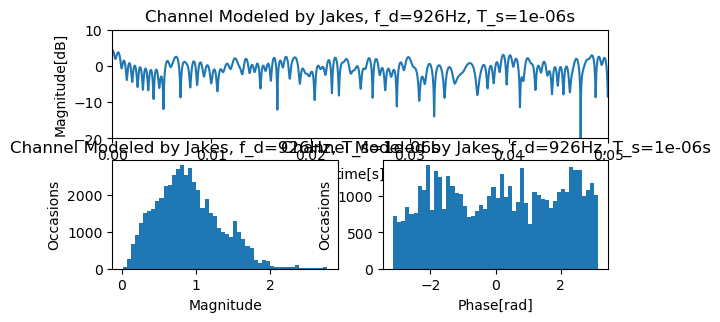

In [158]:
fd = 926
Ts = 1e-6
M = 2 ** 12
t = np.arange(0, M) * Ts
f = np.arange(-M / 2, M / 2) / (M * Ts * fd)
Ns = 50000
t_state = 0

# channel generation
[h, t_state] = Jakes_Flat(fd, Ts, Ns, t_state, 1, 0)

h = h.T

# plotting
plt.subplot(311)
plt.plot(np.arange(1, Ns + 1) * Ts, 10 * np.log10(np.abs(h)))
plt.axis([0, Ns * Ts, -20, 10])
plt.title(f'Channel Modeled by Jakes, f_d={fd}Hz, T_s={Ts}s')
plt.xlabel('time[s]')
plt.ylabel('Magnitude[dB]')

plt.subplot(323)
plt.hist(np.abs(h), 50)
plt.title(f'Channel Modeled by Jakes, f_d={fd}Hz, T_s={Ts}s')
plt.xlabel('Magnitude')
plt.ylabel('Occasions')

plt.subplot(324)
plt.hist(np.angle(h), 50)
plt.title(f'Channel Modeled by Jakes, f_d={fd}Hz, T_s={Ts}s')
plt.xlabel('Phase[rad]')
plt.ylabel('Occasions')

program 2.22 “equalpower_subray”: Look-up table for uniform power subray-based offset
angles

In [159]:
def equalpower_subray(AS_deg):
    if AS_deg == 2:
        theta = np.array([0.0894, 0.2826, 0.4984, 0.7431, 1.0257, 1.3594, 1.7688, 2.2961, 3.0389, 4.3101])
    elif AS_deg == 5:
        theta = np.array([0.2236, 0.7064, 1.2461, 1.8578, 2.5642, 3.3986, 4.4220, 5.7403, 7.5974, 10.7753])
    elif AS_deg == 35:
        theta = np.array([1.5649, 4.9447, 8.7224, 13.0045, 17.9492, 23.7899, 30.9538, 40.1824, 53.1816, 75.4274])
    else:
        print('Not support AS')
        return

    return theta

program 2.23 “assign_offset” to allocate the offset angle for each subray

In [160]:
def assign_offset(AoA_deg, AS_deg):
    offset = equalpower_subray(AS_deg)
    tmp = np.concatenate([[offset], [-offset]])
    tmp = tmp.ravel('F')
    theta_AoA_deg = np.tile(np.matrix(AoA_deg).T, (1, 2 * len(offset))) + np.tile(tmp, (len(AoA_deg), 1))
    return theta_AoA_deg

program 2.24 “gen_phase” to generate the phase for each subray

In [161]:
def gen_phase(BS_theta_LOS_deg, BS_AS_deg, BS_AoD_deg, MS_theta_LOS_deg, MS_AS_deg, MS_AoA_deg, M=20):
    BS_PHI_rad = 2 * np.pi * np.random.rand(len(BS_AoD_deg), M)
    BS_theta_deg = assign_offset(BS_theta_LOS_deg + BS_AoD_deg, BS_AS_deg)
    MS_theta_deg = assign_offset(MS_theta_LOS_deg + MS_AoA_deg, MS_AS_deg)
    index = np.random.permutation(M)
    MS1 = MS_theta_deg.shape[0]
    for n in range(MS1):
        MS_theta_deg[n, :] = MS_theta_deg[n, index]

    return BS_theta_deg, MS_theta_deg, BS_PHI_rad

 program 2.25 “ray_fading” to generate the fading for each subray

In [162]:
def ray_fading(M, PDP, BS_PHI_rad, MS_theta_deg, v_ms, theta_v_deg, lambda_1, t):
    MS_theta_rad = np.deg2rad(MS_theta_deg)
    theta_v_rad = np.deg2rad(theta_v_deg)
    # generate channel coefficients

    h = []

    for n in range(len(PDP)):
        # TODO test Matrix multiply

        m1 = np.matrix(np.exp(-1j * BS_PHI_rad[n, :])).conj().T

        m3 = -1j * 2 * np.pi / lambda_1 * v_ms * np.cos(MS_theta_rad[n, :] - theta_v_rad).conj().T

        m2 = np.exp(m3 @ np.matrix(t))

        m4 = m1 @ np.matrix(np.ones(t.shape))

        tmph = np.asarray(m4) * np.asarray(m2)

        h.append(np.sqrt(PDP[n] / M) * np.sum(tmph, axis=0))

    # TODO test matrix
    h = np.matrix(h)

    return h

 program 2.26 “dB2W” for dB-to-watt conversion

In [163]:
def dB2w(dB):
    return 10 ** (0.1 * dB)

### program 2.21

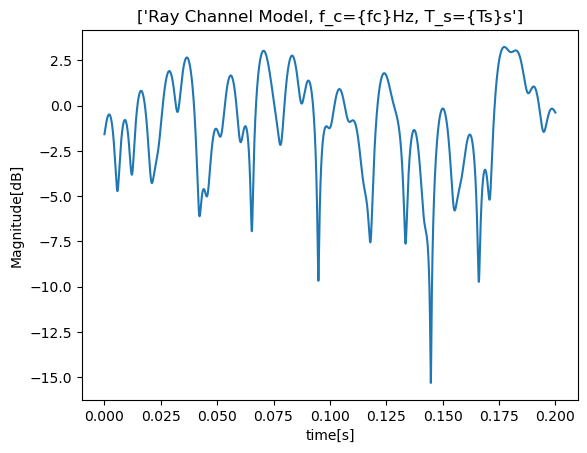

In [164]:
fc = 9e8  # 2e9   # 2GHz
fs = 5e4  # 5[MHz]
speed_kmh = 120  # 3     # 3[km/h]
Ts = 1 / fs  # sampling frequency in sec
v_ms = speed_kmh / 3.6  # velocity[m/s]
wl_m = 3e8 / fc  # wavelength[m]
# channel parameters setting: SCM cas
PDP_dB = np.array([0., -1., -9., -10., -15., -20])
t_ns = np.array([0, 310, 710, 1090, 1730, 2510])
BS_theta_LOS_deg = 0
MS_theta_LOS_deg = 0
BS_AS_deg = 2  # Laplacian PAS
BS_AoD_deg = 50 * np.ones(PDP_dB.shape)
MS_AS_deg = 35  # for Lapalcian PAS
DoT_deg = 22.5
MS_AoA_deg = 67.5 * np.ones(PDP_dB.shape)

# generates phase of a subray
BS_theta_deg, MS_theta_deg, BS_PHI_rad = gen_phase(BS_theta_LOS_deg, BS_AS_deg, BS_AoD_deg, MS_theta_LOS_deg,
                                                   MS_AS_deg, MS_AoA_deg)
PDP = dB2w(PDP_dB)

# generates coefficients
t = np.arange(0, 10000) * Ts
h = ray_fading(20, PDP, BS_PHI_rad, MS_theta_deg, v_ms, DoT_deg, wl_m, t)
plt.plot(t, 10 * np.log10(np.abs(h[0, :].T)))
plt.title(['Ray Channel Model, f_c={fc}Hz, T_s={Ts}s'])
plt.xlabel('time[s]')
plt.ylabel('Magnitude[dB]')

plt.show()


Program 2.28 “SUI_parameters” to set the SUI channel model parameters

In [165]:
def SUI_parameters(ch_no):
    if ch_no < 1 or ch_no > 6:
        print('Not supports channnel number')
        return
    Delays = np.array([[0, 0.4, 0.9], [0, 0.4, 1.1], [0, 0.4, 0.9], [0, 1.5, 4], [0, 4, 10], [0, 14, 20]])
    Powers = np.array([[0, -15, -20], [0, -12, -15], [0, -5, -10], [0, -4, -8], [0, -5, -10], [0, -10, -14]])
    Ks = np.array([[4, 0, 0], [2, 0, 0], [1, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]])
    Dopplers = np.array([[0.4, 0.3, 0.5], [0.2, 0.15, 0.25], [0.4, 0.3, 0.5],
                         [0.2, 0.15, 0.25], [2, 1.5, 2.5], [0.4, 0.3, 0.5]])
    Ant_corrs = np.array([0.7, 0.5, 0.4, 0.3, 0.5, 0.3])
    Fnorms = np.array([-0.1771, -0.393, -1.5113, -1.9218, -1.5113, -0.5683])

    ch_no -= 1

    Delay_us = Delays[ch_no, :],
    Power_dB = Powers[ch_no, :]
    K_factor = Ks[ch_no, :]
    Doppler_shift_Hz = Dopplers[ch_no, :]
    Ant_corr = Ant_corrs[ch_no]
    Fnorm_dB = Fnorms[ch_no]

    return Delay_us, Power_dB, K_factor, Doppler_shift_Hz, Ant_corr, Fnorm_dB

 program 2.29 “SUI_fading”: FWGN (filtered white Gaussian noise) for SUI channel
model

In [166]:
def SUI_fading(P_dB, K_factor, Dopplershift_Hz, Fnorm_dB, N, M, Nfosf):
    Power = 10 ** (P_dB / 10)  # calculate linear power
    s2 = Power / (K_factor + 1)  # calculate variance
    s = np.sqrt(s2)
    m2 = Power * (K_factor / (K_factor + 1))  # calculate constant power
    m = np.sqrt(m2)  # calculate constant part
    L = len(Power)  # number of tabs
    # TODO check max
    fmax = np.max(Dopplershift_Hz, axis=0)
    tf = 1 / (2 * fmax * Nfosf)
    if np.isscalar(Dopplershift_Hz):
        Dopplershift_Hz = Dopplershift_Hz * np.ones(1, L)

    path_wgn = np.sqrt(1 / 2) * (np.random.randn(L, N) + 1j * np.random.randn(L, N))

    path = []

    # TODO test concatenate
    # TODO test fftfilt

    for p in range(L):
        filt = gen_filter(Dopplershift_Hz[p], fmax, M, Nfosf, 'sui', None)
        path.append(
            sg.convolve(filt, np.concatenate([path_wgn[p, :], np.zeros(M)]), 'full', 'direct')
        )  # filtering WGN

    path = np.array(path)
    # TODO check N
    FadMtx = path[:, M // 2:(M // 2) + N]
    for i in range(L):
        FadMtx[i, :] = FadMtx[i, :] * s[i] + m[i] * np.ones(N)

    FadMtx = FadMtx * 10 ** (Fnorm_dB / 20)

    return FadMtx, tf

program 2.27  “plot_SUI_channel.m” to plot an SUI channel model

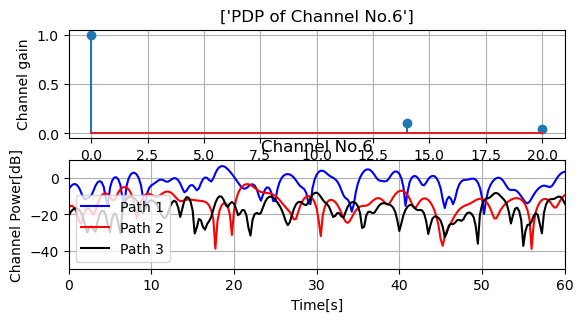

In [167]:
ch_no = 6
fc = 2e9
fs_Hz = 1e7
Nfading = 1024  # Size of Doppler filter
N = 10000
Nos = 4

Delay_us, P_dB, K_factor, Dopplershift_Hz, Ant_corr, Fnorm_dB = SUI_parameters(ch_no)

FadTime, tf = SUI_fading(P_dB, K_factor, Dopplershift_Hz, Fnorm_dB, N, Nfading, Nos)

K1 = FadTime.shape[1] - 1
c_table = ['b', 'r', 'k', 'm']

plt.subplot(311)
plt.stem(np.array(Delay_us).ravel(), 10 ** (P_dB / 10))
plt.grid(True)
plt.xlabel('Delay time[ms]')
plt.ylabel('Channel gain')
plt.title([f'PDP of Channel No.{ch_no}'])

plt.subplot(312)
for k in range(len(P_dB)):
    plt.plot(np.arange(0, K1 + 1) * tf, 20 * np.log10(np.abs(FadTime[k, :])), c_table[k])

plt.grid(True)
plt.xlabel('Time[s]')
plt.ylabel('Channel Power[dB]')
plt.title(f'Channel No.{ch_no}')
plt.axis([0, 60, -50, 10])
plt.legend(['Path 1', 'Path 2', 'Path 3'])
# set(gca,'fontsize',9)

# idx_nonz= find(Dopplershift_Hz)
# FadFreq= ones(length(Dopplershift_Hz),Nfading)

plt.show()

# chapter 3

program 3.1  “channel_coeff” to generate a correlated MIMO fading channel

In [168]:
def channel_coeff(NT, NR, N, Rtx=None, Rrx=None, type=None):
    """
    correlated Rayleigh MIMO channel coefficient
    :param NT: number of transmitters
    :param NR: number of receivers
    :param N: legnth of channel matrix
    :param Rtx: correlation vector/matrix of Tx (e.g.) [1 0.5], [1 0.5;0.5 1]
    :param Rrx: correlation vecotor/matrix of Rx
    :param type: correlation type: 'complex' or 'field'
    :return: NR x NT x N correlated channel
    """
    h = np.sqrt(1 / 2) * (np.random.randn(NT * NR, N) + 1j * np.random.randn(NT * NR, N))
    if Rtx is None:
        return h

    if type == 'complex':
        C = np.lilang.cholesky(np.kron(Rtx, Rrx)).conj().T
    else:
        C = scipy.linalg.sqrtm(np.sqrt(np.kron(Rtx, Rrx)))  # Power (field) correlation

    hh = np.zeros(NR, NT, N)

    for i in range(N):
        tmp = C * h[:, i]
        hh[:, :, i] = np.reshape(tmp, NR, NT)

    return hh


# Chapter 4 - Introduction to OFDM

Program 4.1 “test_orthogonality.m” to test the orthogonality among sinusoidal signals

Program 4.2 “OFDM_basic.m” to simulate an OFDM transmission system

In [171]:

import matlab.engine

def guard_interval(Ng,Nfft,NgType,ofdmSym):


    
    if NgType==1:
        a=ofdmSym[Nfft-Ng:Nfft-1]
        b=ofdmSym[0:Nfft-1]
        y=np.concatenate([a, b])
    elif NgType==2:
        a=np.zeros((1,Ng))
        b=ofdmSym[0:Nfft-1]
        y=np.concatenate([a, b])
    return y


def remove_GI(Ng,Lsym,NgType,ofdmSym):
    # % MIMO-OFDM Wireless Communications with MATLAB¢ç   Yong Soo Cho, Jaekwon Kim, Won Young Yang and Chung G. Kang
    # % 2010 John Wiley & Sons (Asia) Pte Ltd

    # % http://www.wiley.com//legacy/wileychi/cho/

    if Ng!=0:
        if NgType==1:  #% cyclic prefix|Ñ­»·Ç°×º
            y=ofdmSym[Ng:Lsym-1]
        elif NgType==2: # cyclic suffix|Ñ­»·ºó×º
            y=ofdmSym[0:Lsym-Ng-1]+[ofdmSym[Lsym-Ng:Lsym-1],np.zeros[1,Lsym-2*Ng]]
    
    else:
        y=ofdmSym
    return y

eng=matlab.engine.start_matlab()
NgType=1

if NgType==1:
    nt='CP'  
elif NgType==2:
    nt='ZP'
Ch=1  # Ch=0/1 for AWGN/multipath channel|对于AWGN/多径瑞利信道，channelCh=0/1

if Ch==0:
    chType='AWGN' 
    Target_neb=100 
else:
    chType='CH'
    Target_neb=500
# figure(Ch+1), clf
PowerdB=[0, -8, -17, -21, -25] ## Channel tap power profile 'dB'|信道抽头功率特性 'dB'
PowerdB=np.array(PowerdB)
Delay=[0, 3, 5, 6, 8]         # Channel delay 'sample'|信道时延（采样点）
Power=[]
# Power=10^(PowerdB/10)     # Channel tap power profile 'linear scale'|信道抽头功率特性（线性尺度）
for i in (PowerdB/10):
    Power.append(10**i)
Power=np.array(Power)
Ntap=len(PowerdB)       # Chanel tap number|信道抽头数
Lch=Delay[-1]+1           # Channel length|信道长度
Nbps=4 
M=2**Nbps  # Modulation order=2/4/6 for QPSK/16QAM/64QAM|调制阶数=2/4/6：QPSK/16QAM/64QAM
Nfft=64           # FFT size|FFT大小
Ng=3

Nsym=Nfft+Ng      # Symbol duration|符号周期
Nvc=Nfft/4       # Nvc=0: no virtual carrier|Nvc=0：没有VC
Nused=int(Nfft-Nvc)

# EbN0=[0:5:20]    # EbN0
EbN0=np.array(range(0, 20+1, 5))
N_iter=int(1e5)       # Number of iterations for each EbN0|对于每一个EbN0的迭代次数
Nframe=3         # Number of symbols per frame|每一帧的符号数
sigPow=0         # Signal power initialization|初始信号功率
file_name=f'OFDM_BER_{chType}_{nt}_GL{str(Ng)}.dat'
# fid=fopen(file_name, 'w+')
# fid=open(file_name,'r')
fid=5
norms=np.array([1, math.sqrt(2), 0, math.sqrt(10), 0, math.sqrt(42)])
for ind,ele in enumerate(EbN0):
    # randn('state',0) 
    # rand('state',0)
    Ber=0 #The original code is Ber2=ber() can't run # BER initialization |initialize BER
    Neb=0
    Ntb=0
    for m in range(1,N_iter+1):
        X= np.random.randint(16,size=(int(Nused*Nframe),int(M)) )# bit: integer vector
        X=matlab.double(X.tolist())
        # Xmod= eng.qammod(X,M,'gray')/norms(Nbps)
        Xmod= eng.qammod(X,M,'gray')
        Xmod=Xmod/norms[Nbps-1]
        # import scipy.io
        # mat = scipy.io.loadmat('Xmod.mat')
        # Xmod=mat['Xmod']
        if NgType!=2:
            x_GI=np.zeros((1,Nframe*Nsym))
        elif NgType==2:
            x_GI= np.zeros((1,Nframe*Nsym+Ng))
            # Ext an OFDM symbol by Ng zeros |用Ng个零扩展OFDM符号
        
        kk1=np.array(range(1,int(Nused/2)+1)) -1
        kk2=np.array(range(int(Nused/2+1),int(Nused+1)))-1
        kk3=np.array(range(1,Nfft+1)) -1
        kk4=np.array(range(1,Nsym+1))-1
        row,col=Xmod.shape
        for k in range(1,Nframe+1):
            if Nvc!=0:
                # X_shift2= [Xmod[kk2,0], np.zeros((1,int(Nvc)-1),dtype=np.complex_)[0], Xmod[kk1,0]]
                temp=[0+0j]
                for i in kk2:
                    if i<=row:
                        temp.append(Xmod[i][0])
                    else:
                        temp.append(Xmod[row%i][row//i])
                
                for i in range(16):
                    temp.append(0.+0.j)

                for i in kk1:
                    if i<=row:
                        temp.append(Xmod[i][0])
                    else:
                        temp.append(Xmod[row%i][row//i])
                
                X_shift=temp
                
            else:
                pass
                # X_shift= [Xmod[kk2], Xmod[kk1]]
            Y = np.array(X_shift)
            # x= eng.ifft(matlab.double(X_shift))
            x=np.fft.ifft(Y)
            x_GI[kk4]= guard_interval(Ng,Nfft,NgType,x)
            kk1=kk1+Nused
            kk2= kk2+Nused 
            kk3=kk3+Nfft
            kk4=kk4+Nsym

        if Ch==0:
            y= x_GI  # No channel|没有信道
        else:  # Multipath fading channel|多径衰落信道
            from scipy.stats import norm
            np.random.seed(1)
            
            channel=np.multiply(norm.ppf(np.random.rand(1,Ntap))+1j*norm.ppf(np.random.rand(1,Ntap)),np.sqrt(Power/2))
            # channel=(randn(1,Ntap)+j*randn(1,Ntap)).*sqrt(Power/2)
            h=np.zeros((1,Lch))
            h[Delay]=channel ## cir: channel impulse response|信道脉冲响应
            y = np.convolve(x_GI,h, mode='full')
            # scipy.signal.fftconvolve(x, y, mode='full', axes=None)
            # scipy.signal.oaconvolve(x, y, mode='full', axes=None)
            # 

        if ind==0: # Only to measure the signal power for adding AWGN noise|只测量信号功率
            y1=y[0:(Nframe*Nsym)-1] 
            sigPow = sigPow + y1*y1.T
            continue



        # Add AWGN noise________________________________________________|加AWGN噪声
        snr = EbN0(ind)+10*math.log10(Nbps*(Nused/Nfft)); # SNR vs. Eb/N0|式4.28，由频域SNR算时域SNR
        noise_mag = math.sqrt((10.^(-snr/10))*sigPow/2); # N0=Eb/SNR
        y_GI = y + noise_mag*(norm.ppf(np.random.rand(1,len(y))))+1j*norm.ppf(np.random.rand(1,len(y)))
        # y_GI = y + noise_mag*(randn(size(y))+j*randn(size(y)))
        # Rx_____________________________________________________________
        # kk1=(NgType==2)*Ng+[1:Nsym]; 
        kk1=range(Nsym)
        kk2=range(Nfft)
        kk3=range(Nused) 
        kk4=range(Nused/2+Nvc,Nfft-1) 
        # kk5=(Nvc~=0)+[1:Nused/2]
        kk5=range(0,int(Nused/2-1))+1
        if Ch==1:
            H= np.fft.fft(h, np.zeros(1,Nfft-Lch)); # Channel frequency response|信道频率响应
            H_shift[kk3]= np.array(H[kk4] H[kk5])
         
        for k in range(Nframe):
            Y[kk2]= np.fft.fft(remove_GI(Ng,Nsym,NgType,y_GI(kk1)))
            Y_shift=np.array(Y[kk4],Y[kk5])
            if Ch==0:
                Xmod_r[kk3] = Y_shift
            else:
                Xmod_r[kk3]= np.devide(Y_shift,H_shift ) # Equalizer - channel compensation|均衡器
             
            kk1=kk1+Nsym
            kk2=kk2+Nfft 
            kk3=kk3+Nused 
            kk4=kk4+Nfft 
            kk5=kk5+Nfft
         
#         X_r=qamdemod(Xmod_r*norms(Nbps),M,0,'gray');
        X_r=eng.qamdemod(Xmod_r*norms(Nbps),M,'gray')
        Neb=Neb+sum(sum(eng.de2bi(X_r.T,Nbps)!=eng.de2bi(X[:,1],Nbps)))
        #       Neb=Neb+sum(sum(de2bi(X_r,Nbps)~=de2bi(X,Nbps)));
        Ntb=Ntb+Nused*Nframe*Nbps;  #[Ber,Neb,Ntb]=ber(bit_Rx,bit,Nbps);
        if Neb>Target_neb:
            break 
         
    if ind==0:
            sigPow= sigPow/Nsym/Nframe/N_iter
            # fprintf('Signal power= %11.3e\n', sigPow);
            # fprintf(fid,'%%Signal power= %11.3e\n%%EbN0[dB]       BER\n', sigPow);
    else:
        Ber = Neb/Ntb
        # fprintf('EbN0=%3d[dB], BER=%4d/%8d =%11.3e\n', EbN0(i), Neb,Ntb,Ber)
        # fprintf(fid, '%d\t%11.3e\n', EbN0(i), Ber);
        if Ber<1e-6:
            break
# if (fid!=0):  
#     fclose(fid)
#     end
print('Simulation is finished')
import matplotlib.pyplot as plt
plt.plot(Nbps)      
        
print("hi")




SyntaxError: invalid syntax (2434001603.py, line 180)

# Chapter 5- Synchronization for OFDM

Program 5.1 “add_STO” for adding STO to the received signal

In [173]:

def add_STO(y, nSTO):
# % add STO (symbol time offset)
# % y : Received signal
# % nSTO : Number of samples corresponding to STO
    if nSTO>=0:
        z=y.reshape(1, -1)
        z=z[:,nSTO-1:-1]
        # a=y[nSTO,-1]
        b=np.zeros((1,nSTO))
        y_STO= np.concatenate((z, b), axis=1)#% advance
    else :
        a=np.zeros((1,-nSTO))
        z=y.reshape(1, -1)
        z=z[:,0:-1+nSTO]
        y_STO=np.concatenate((a, z), axis=1) #% delay

    return y_STO

Program 5.2 “add_CFO” for adding CFO to the received signal

In [175]:
def add_CFO(y,CFO,Nfft):
# % add CFO (carrier frequency offset)
# % y : Received signal
# % CFO = IFO (integral CFO) + FFO (fractional CFO)
# % Nfft = FFT size
    r,c=y.shape
    nn=np.arange(c)
    # CFO=int(CFO)

    y_CFO = np.multiply(y,np.exp(1j*2*math.pi*CFO*nn/Nfft)) # Eq.(5.7)
    return y_CFO


Program 5.3 “STO_estimation.m”: CP-based symbol timing offset (STO) estimation

In [177]:
import matlab.engine
eng=matlab.engine.start_matlab()
import math
from math import pi
import numpy as np
import scipy.fft
import matplotlib.pyplot as plt

nSTOs = np.array([-3, -3, 2, 2])
CFOs = np.array([0, 0.5, 0, 0.5])

SNRdB=30; 
MaxIter=10; 
Nfft=128; 
Ng=Nfft/4; 
Nofdm=Nfft+Ng; 
Nbps=2; 
M=2**Nbps; 

Es=1; 
A=math.sqrt(3/2/(M-1)*Es) 
N=Nfft;  
com_delay = Nofdm/2
Nsym=100

from add_CP import add_CP
from add_CFO import add_CFO
from add_STO import add_STO
from STO_by_correlation import STO_by_correlation
from STO_by_difference import STO_by_difference
from awgn import awgn


from scipy.stats import norm
np.random.seed(1)
h=list()
h.append(complex(norm.ppf(np.random.rand(1,1))[0][0],norm.ppf(np.random.rand(1,1))[0][0]))
h.append(0*1j)
h.append(0*1j)
h.append(0*1j)
h.append(complex(norm.ppf(np.random.rand(1,1))[0][0],norm.ppf(np.random.rand(1,1))[0][0])/math.sqrt(16))
h.append(complex(norm.ppf(np.random.rand(1,1))[0][0],norm.ppf(np.random.rand(1,1))[0][0])/math.sqrt(18))
h=np.array(h)
h=h/math.sqrt(2)

# h=[,0*1j,0*1j,0*1j,complex(norm.ppf(np.random.rand(1,1))[0][0],norm.ppf(np.random.rand(1,1))[0][0])/math.sqrt(16),complex(norm.ppf(np.random.rand(1,1))[0][0],norm.ppf(np.random.rand(1,1))[0][0])/math.sqrt(18)]/math.sqrt(2)
# h=0.5.**[0:5]

h=np.array(range(6))
h=h**0.5

h=list()
h.append(complex(norm.ppf(np.random.rand(1,1))[0][0],norm.ppf(np.random.rand(1,1))[0][0]))
h.append(0.5*complex(norm.ppf(np.random.rand(1,1))[0][0],norm.ppf(np.random.rand(1,1))[0][0]))
h.append(0.25*complex(norm.ppf(np.random.rand(1,1))[0][0],norm.ppf(np.random.rand(1,1))[0][0]))
h.append(0.125*complex(norm.ppf(np.random.rand(1,1))[0][0],norm.ppf(np.random.rand(1,1))[0][0]))
h.append(0.0625*complex(norm.ppf(np.random.rand(1,1))[0][0],norm.ppf(np.random.rand(1,1))[0][0]))
h.append(0.03125*complex(norm.ppf(np.random.rand(1,1))[0][0],norm.ppf(np.random.rand(1,1))[0][0]))
h=np.array(h)
K=4
fig, ax = plt.subplots(K)

for i , ele in enumerate(nSTOs):

    nSTO= ele  
    CFO= CFOs[i]


    x = np.empty((160,0))
    #    Xf=np.zeros((N,M))
    for m in range(Nsym):
        msgint=np.random.randint(2, size=(N,M))
        msgint=matlab.double(msgint.tolist())
        Xf= A*np.array(eng.qammod(msgint,M))
        # Xf=matlab.double(Xf.tolist())
        xt=scipy.fft.ifft(Xf)
        # xt = eng.ifft(Xf,Nfft)

        x_sym = add_CP(xt.T,Ng)
        x=np.concatenate((x,x_sym.T),axis=1)
   

    y = x 

    sig_pow = y.dot(y.T)/len(y)

    y_CFO= add_CFO(y,CFO,Nfft); 
    y_CFO_STO= add_STO(y_CFO,-nSTO)
    v_ML=np.zeros((1,int(Ng)))
    v_Cl=np.zeros((1,int(Ng)))
    Mag_cor= 0
    Mag_dif= 0
   
    for iter in range(MaxIter):
        # y_CFO_STO=matlab.double(y_CFO_STO.tolist())
        # y_aw = eng.awgn(y_CFO_STO,SNRdB,'measured')
        y_aw=awgn(y_CFO_STO,SNRdB)
        STO_cor,mag_cor= STO_by_correlation(y_aw,Nfft,int(Ng),int(com_delay))
        STO_dif,mag_dif= STO_by_difference(y_aw,Nfft,int(Ng),int(com_delay))
        Mag_cor= Mag_cor+mag_cor
        Mag_dif= Mag_dif+mag_dif
    
    Mag_cor_max = np.max(Mag_cor)
    ind_max=np.argmax(Mag_cor)
    nc= ind_max-1-com_delay
    Mag_dif_min = np.min(Mag_dif)
    ind_min=np.argmin(Mag_dif)
    nd= ind_min-1-com_delay

    Mag_cor = Mag_cor/MaxIter

    Mag_cor_max= np.max(Mag_cor) 
    ind_max=np.argmax(Mag_cor)
    nc= ind_max-1-com_delay
    Mag_dif = Mag_dif/MaxIter 
    Mag_dif_min = np.min(Mag_dif)
    ind_min = np.argmin(Mag_dif)
    nd= ind_min-1-com_delay
    temp=len(Mag_cor[0])
    nn=range(temp)
    nn=np.array(nn)
    nn=nn+(-Nofdm/2)
    nt= nSTO

    # plot(nn,Mag_cor,nn,1.5*Mag_dif,'r:','markersize',1)

    # stem(nc,Mag_cor_max,'b','markersize',5)
    # stem(nSTO,Mag_cor(nSTO+com_delay+1),'k.','markersize',5) 
    ax[i].plot(nn,Mag_cor[0], color = 'r',linestyle = '-')
    ax[i].plot(nn,1.5*Mag_cor[0], color = 'b',linestyle = '-')
    # ax[i][0].axhline(y = 0, color = 'r', linestyle = '-')
    # ax[i][0].stem(tts,x[i,nns].real,use_line_collection = True)
    print(f'STO Estimation - ML(b-)/Classen(r:) for nSTO={nSTO}, CFO={CFO}'); 
    # title(str1); 
    # xlabel('Sample'), 
    # ylabel('Magnitude'); 
    # stem(nd,Mag_dif(nd+com_delay+1),'r','markersize',5)
    # stem(nSTO,Mag_dif(nSTO+com_delay+1),'k.','markersize',5) 
    # set(gca,'fontsize',9, 'XLim',[-32 32], 'XTick',[-10 -3 0 2 10]) 
 



# stem(nc,Mag_cor(nc+com_delay+1),'b')


ModuleNotFoundError: No module named 'matlab'

Program 5.4 “STO_by_correlation”: CP-based symbol synchronization using the correlation

In [48]:

import math
import operator

def STO_by_correlation(y,Nfft,Ng,com_delay=0):
# % estimates STO by maximizing the correlation between CP (cyclic prefix)
# % and rear part of OFDM symbol
# % Input: y = Received OFDM signal including CP
# % Ng = Number of samples in Guard Interval (CP)
# % com_delay = Common delay
# % Output: STO_est = STO estimate
# % Mag = Correlation function trajectory varying with time
    Ng=int(Ng)
    Nofdm=Nfft+Ng; #% OFDM symbol length
    com_delay=int(com_delay)
    if com_delay==0:
        com_delay = Nofdm/2
    nn=range(int(Ng))
    
    f = operator.itemgetter(range(com_delay,Ng+com_delay))
    y1 = [list(f(y[0]))]
    f = operator.itemgetter(range(com_delay+Nfft,Ng+com_delay+Nfft))
    y2 = [list(f(y[0]))]
    y1=np.array(y1)
    y2=np.array(y2)

    yy =y1.dot(y2.T)
    yy=yy[0][0]

    maximum=abs(yy)
    Mag=np.zeros((1,Nofdm))
    for ind in range(Nofdm):
        n1 = ind

        yy1 = y[0][n1+com_delay]*y[0][n1+com_delay+Nfft]
        yy2 = y[0][n1+com_delay+Ng]*y[0][n1+com_delay+Nfft+Ng]
        yy = yy-yy1+yy2; 
        Mag[0][ind]=abs(yy); #% Eq.(5.12)
        
        if Mag[0][ind]>maximum:
            maximum=Mag[0][ind]; 
            STO_est=Nofdm-com_delay-n1; 


    return STO_est ,Mag

Program 5.5 “STO_by_difference”: CP-based symbol synchronization using the difference

In [50]:

def STO_by_difference(y,Nfft,Ng,com_delay=0):


    Nofdm=Nfft+Ng
    minimum=100
    STO_est=0
    if com_delay==0: 
        com_delay = Nofdm/2
    Mag=np.zeros((1,Nofdm))
    for ind in range(Nofdm):
        # nn = ind+com_delay+range(Ng) 
        nn= range(ind+com_delay,ind+com_delay+Ng)
        f = operator.itemgetter(nn)
        f2 = operator.itemgetter(np.array(nn)+Nfft)

        y1 = [list(f(y[0]))]
        y2 = [list(f2(y[0]))]

        y1=np.array(y1)
        y2=np.array(y2)

        tmp0 = abs(y1)-abs(y2)
        Mag[0][ind] = tmp0.dot(tmp0.T) # Squared difference by Eq.(5.11)
        if Mag[0][ind]:
            minimum=Mag[0][ind]; 
            STO_est=Nofdm-com_delay-ind
            
    
    return STO_est,Mag

Program 5.6 “CFO_estimation.m” using time/frequency-domain techniques

In [56]:
# import matlab.engine
# eng=matlab.engine.start_matlab()
import math
from math import pi
import numpy as np
import scipy.fft
from add_pilot import add_pilot
from add_CP import add_CP
from add_CFO import add_CFO
from awgn import awgn
from CFO_CP import CFO_CP
from CFO_Moose import CFO_Moose
from CFO_Classen import CFO_Classen
import matplotlib.pyplot as plot


CFO = 0.15
Nfft=128 # FFT size
Nbps=2
M=2**Nbps # Number of bits per (modulated) symbol
# h = modem.qammod('M',M, 'SymbolOrder','gray') 
Es=1
A=math.sqrt(3/2/(M-1)*Es)  # Signal energy and QAM normalization factor
N=Nfft
Ng=Nfft/4
Nofdm=Nfft+Ng
Nsym=3

Xp= add_pilot(np.zeros((1,Nfft)),Nfft,4)
Xf=Xp  # add_pilot
for m in range(Nsym):

    xt = scipy.fft.ifft(Xf,Nfft)  # IFFT
    x_sym = add_CP(xt,int(Ng))  # add CP
    if m==0:
        x=x_sym
    else:
        x=np.concatenate((x,x_sym),axis=1)

y=x # No channel effect
sig_pow= y.dot(y.T)/len(y) # Signal power calculation
# SNRdBs= 0:3:30 
SNRdBs= range(0,30+1,3)
MaxIter = 100

MSE_CP=np.zeros((1,11))
MSE_Moose=np.zeros((1,11))
MSE_Classen=np.zeros((1,11))

for i in range(len(SNRdBs)):
    SNRdB = SNRdBs[i]
    MSE_CFO_CP = 0
    MSE_CFO_Moose = 0
    MSE_CFO_Classen = 0

    y_CFO= add_CFO(y,CFO,Nfft)  # Add CFO
    for iter in range(MaxIter):

        y_aw = awgn(y_CFO,SNRdB) # AWGN added
        CFO_est_CP = CFO_CP(y_aw,Nfft,Ng)  # CP-based
        MSE_CFO_CP = MSE_CFO_CP + (CFO_est_CP[0][0]-CFO)**2
        CFO_est_Moose = CFO_Moose(y_aw,Nfft)  # Moose
        MSE_CFO_Moose = MSE_CFO_Moose + (CFO_est_Moose-CFO)**2
        CFO_est_Classen = CFO_Classen(y_aw,Nfft,Ng,Xp)  # Classen
        MSE_CFO_Classen = MSE_CFO_Classen+(CFO_est_Classen-CFO)**2
    # End of (iter) loop
    MSE_CP[0,i]=MSE_CFO_CP/MaxIter 
    MSE_Moose[0,i]=MSE_CFO_Moose/MaxIter 
    MSE_Classen[0,i]=MSE_CFO_Classen/MaxIter 
# End of SNR loop

plot.grid(True, which ="both")
plot.semilogy(np.array(SNRdBs),MSE_CP[0],'-+')
# grid on
# hold on
plot.semilogy(np.array(SNRdBs),MSE_Moose[0],'-x')
plot.semilogy(np.array(SNRdBs),MSE_Classen[0],'-*')
plot.xlabel('SNR[dB]')
plot.ylabel('MSE') 
plot.title('CFO Estimation')
# plot.title('CP-based technique','Moose','Classen')
plot.legend(['MSE_CP', 'MSE_Moose','MSE_Classen'])
plot.show()

ModuleNotFoundError: No module named 'matlab'

Program 5.7 “CFO_CP”: Time-domain technique using CP

In [57]:
from math import pi
# import matlab.engine
# eng=matlab.engine.start_matlab()
import numpy as np
import operator


def CFO_CP(y,Nfft,Ng):
#% Time-domain CFO estimation based on CP (Cyclic Prefix)
    nn=np.arange(int(Ng))
    f = operator.itemgetter(nn+Nfft)
    y1 = [list(f(y[0]))]
    y1=np.array(y1)
    f = operator.itemgetter(nn)
    y2 = [list(f(y[0]))]
    y2=np.array(y2)
    temp=y1.dot(y2.T)
    # temp=matlab.double(temp[0].tolist())
    CFO_est = np.angle(temp)/(2*pi) # Eq.(5.27)
    return CFO_est

Program 5.8 “CFO_Moose”: Frequency-domain technique using preamble

In [59]:
# import matlab.engine
# eng=matlab.engine.start_matlab()
from math import pi
import numpy as np
import scipy.fft

def CFO_Moose(y,Nfft):
    # % Frequency-domain CFO estimation using Moose method
    # % based on two consecutive identical preambles (OFDM symbols)
    ii=[0,1]
    Y=[]
    for i in ii:
        Y.append(scipy.fft.fft(y[0,Nfft*i:Nfft*(i+1)],Nfft))
    Y=np.array(Y)
    CFO_est = np.angle(Y[0][1]*Y[0][0].T)/(2*pi) #% Eq.(5.30)

    return CFO_est

Program 5.9 “CFO_Classen”: Frequency-domain technique using pilot tones

In [61]:
import matlab.engine
eng=matlab.engine.start_matlab()
from math import pi
import numpy as np
from add_pilot import add_pilot
import scipy.fft


def remove_CP(x,Ncp):

    y=x[int(Ncp):-1]
    return y

def CFO_Classen(yp,Nfft,Ng,Nps):
    # # Frequency-domain CFO estimation using Classen method
    # # based on pilot tones in two consecutive OFDM symbols
    if len(Nps[0])==1:
        Xp=add_pilot(np.zeros((1,Nfft)),Nfft,Nps); # Pilot signal
    else:
        Xp=Nps[0]; # If Nps is an array, it must be a pilot sequence Xp
    
    Nofdm=Nfft+Ng
    Yp=[]
    # msgint=matlab.double(Xp.tolist())
    kk=np.nonzero(Xp)

    Xp=Xp[kk] # Extract pilot tones
    
    for i in range(2):
        yp_without_CP = remove_CP(yp[0,int(Nofdm)*(i):int(Nofdm)*(i+1)],Ng)
        Yp.append(scipy.fft.fft(yp_without_CP,Nfft))
    Yp=np.array(Yp)
    a1=Yp[1,kk]*Xp
    b1=Yp[0,kk]*Xp
    CFO_est = np.angle(a1.dot(b1.T))/(2*pi); # Eq.(5.31)
    CFO_est = CFO_est*Nfft/Nofdm # Eq.(5.31)

    return CFO_est

ModuleNotFoundError: No module named 'matlab'

Program 5.10 “add_pilot” to generate and insert a pilot sequence

In [63]:
import matlab.engine
eng=matlab.engine.start_matlab()
from math import pi
import math

def  add_pilot(x,Nfft,Nps=4):
# CAZAC (Constant Amplitude Zero AutoCorrelation) sequence –> pilot
# Nps : Pilot spacing

    Np=Nfft/Nps # Number of pilots
    xp=x.astype(complex) # Prepare an OFDM signal including pilot signal for initialization
    for k in range(int(Np)):
        # print(np.exp(1j*pi*k**2/Np))
        xp[0,k*Nps]=np.exp(1j*pi*k**2/Np) # Eq.(7.17) for Pilot boosting
    return xp


ModuleNotFoundError: No module named 'matlab'

 Program 5.11 “add_CP” to add CP

In [65]:
import matlab.engine
eng=matlab.engine.start_matlab()
from math import pi
import numpy as np


def add_CP(x,Ng):
# Add CP (Cyclic Prefix) of length Ng
    r,c=x.shape
    Ng=int(Ng)
    y = np.concatenate((x[:,c-Ng:c], x),axis=1)
    return y


ModuleNotFoundError: No module named 'matlab'

Program 5.12 “remove_CP” to remove CP

In [67]:
import matlab.engine
eng=matlab.engine.start_matlab()
from math import pi
import numpy as np

def remove_CP(x,Ng,Noff=0):
# Remove CP (Cyclic Prefix) of length Ng

    y=x[:,Ng-Noff:-1-Noff]

    return y

ModuleNotFoundError: No module named 'matlab'

# Chapter 6 Channel Estimation

Program 6.1 “LS_CE” for LS channel estimation method

In [69]:
def LS_CE(Y: np.ndarray, Xp: np.ndarray, pilot_loc: np.ndarray, Nfft:int, Nps:int, int_opt: str):
    Np = Nfft / Nps
    k = np.arange(1, Np)
    LS_est = Y[pilot_loc[k]]/Xp[k]
    method = 'linear' if int_opt.lower() == 'l' else 'spline'
    # H_LS = sc.interpolate.datagrid(LS_est, pilot_loc, Nfft, method)
    H_LS = interpolate(LS_est, pilot_loc, Nfft, method)
    return H_LS

Program 6.2 “MMSE_CE” for MMSE channel estimation method

In [71]:
def MMSE_CE(Y, Xp, pilot_loc, Nfft, Nps, h: np.ndarray, SNR):
    snr = 10 ** (SNR * 0.1)
    Np = Nfft / Nps
    k = np.arange(1, Np)
    H_tilde = Y[1, pilot_loc[k]] / Xp[k]
    k = np.arange(0, h.shape[0] - 1)
    hh = h.dot(np.transpose(h))
    tmp = h.dot(np.conjugate(h)).dot(h)
    r = np.sum(tmp) / hh
    r2 = tmp.dot(np.transpose(k)) / hh
    tau_rms = sqrt(r2 - r ** 2)  # rms delay
    df = 1 / Nfft  # 1/(ts*Nfft)
    j2pi_tau_df = j.dot(2).dot(pi).dot(tau_rms).dot(df)

    K1 = np.matlib.repmat(np.transpose(np.arange(0,Nfft-1)), 1, Np)
    K2 = np.matlib.repmat(np.arange(0, Np-1), Nfft, 1)
    rf = 1/(1+j2pi_tau_df.dot(Nps).dot(K1-K2))  # Eq.(6.17a)
    K3 = np.matlib.repmat(np.transpose(np.arange(0, Np-1)), 1, Np)
    K4 = np.matlib.repmat(np.arange(0,Np-1), Np, 1)
    rf2 = 1/(1+j2pi_tau_df.dot(Nps).dot(K3-K4))  # Eq.(6.17a)
    Rhp = rf
    Rpp = rf2 + np.eye(H_tilde.shape[0], H_tilde.shape[0]) / snr  # Eq.(6.14)
    H_MMSE = np.transpose(Rhp.dot(inv(Rpp)).dot(np.transpose(H_tilde)))  # MMSE estimate Eq.(6.15)
    return H_MMSE


Program 6.3 “interpolate” for channel interpolation between pilots

In [73]:
def interpolate(H, pilot_loc, Nfft, method):
    if pilot_loc(0) > 1:
        slope = (H[1] - H_est[0]) / (pilot_loc[1] - pilot_loc[0])
        H = np.array([H[0] - slope * (pilot_loc[0] - 1), H])
        pilot_loc = np.array([0, pilot_loc])

    if pilot_loc[-1] < Nfft:
        slope = (H[-1]-H[-1-1])/(pilot_loc[-1]-pilot_loc[-1-1])
        H = np.array([H, H[-1]+slope*(Nfft-pilot_loc[-1])])
        pilot_loc = np.array([pilot_loc, Nfft])

    if lower(method[0]) == 'l':
        H_interpolated = sc.interpolate.interp1d(
            pilot_loc, H, np.arange(1, Nfft))
    else:
        H_interpolated = sc.interpolate.interp1d(
            pilot_loc, H, np.arange(1, Nfft), 'spline')

    return H_interpolated

Program 6.4 “channel_estimation.m” for DFT-based channel estimation

In [76]:
def awgn(y_channel, SNR):
     gamma = 10 ** (SNRdB / 10)  # SNR to linear scale
    if y_channel.ndim==1:# if s is single dimensional vector
        P = L * np.sum(np.abs(y_channel) ** 2) / len(y_channel) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P = L * np.sum(np.sum(np.abs(y_channel) ** 2)) / len(y_channel) # if s is a matrix [MxN]
    N0=P / gamma # Find the noise spectral density
    if isrealobj(y_channel):# check if input is real/complex object type
        n = np.sqrt(N0 / 2) * np.random.standard_normal(y_channel.shape) # computed noise
    else:
        n = np.sqrt(N0 / 2) * (np.random.standard_normal(y_channel.shape) + 1j * np.random.standard_normal(y_channel.shape))
    r = s + n # received signal
    return r

axis_fig1 = [fig1.add_subplot(321 + 2 * i) for i in range(3)]
axis_fig2 = [fig2.add_subplot(221), fig2.add_subplot(222)]
axis_fig3 = [fig3.add_subplot(111)]

Nfft = 32
Ng = Nfft / 8
Nofdm = Nfft + Ng
Nsym = 100
Nps = 4
Np = Nfft / Nps  # Pilot spacing and number of pilots per OFDM symbol
Nbps = 4
M = 2 ** Nbps  # Number of bits per (modulated) symbol
mod_object = QAMModem(Nbps).modulate('M', M, 'SymbolOrder', 'gray')
demod_object = modem(Nbps).demodulate('M', M, 'SymbolOrder', 'gray')
Es = 1
A = np.sqrt(3 / 2 / (M - 1) * Es)  # Signal energy and QAM normalization factor
SNR = 30
sq2 = np.sqrt(2)
MSE = np.zeros(1, 6)
nose = 0


for nsym in range(0, Nsym):
    Xp = 2 * (np.randn(1, Np) > 0) - 1          # Pilot sequence generation
    msgint = rnd.randint(1, Nfft - Np, M)       # bit generation
    Data = A * modulate(mod_object, msgint)
    ip = 0
    pilot_loc = np.array([])
    for k in range(0, Nfft):
        if k % Nps == 1:
            X[k] = Xp[floor(k / Nps) + 1]
            pilot_loc = np.array([pilot_loc, k])
            ip = ip + 1
        else:
            X[k] = Data[k - ip]

x = np.fft.ifft(X, Nfft)
xt = [x[Nfft - Ng + 1 : Nfft], x] # IFFT and add CP
h = np.array([(np.random.randn() + j * np.random.randn()), 
                (np.random.randn() + j * np.random.randn()) / 2]) # A (2-tap) channel
H = np.fft.fft(h, Nfft)
ch_length= h.shape[0] # True channel and its length
H_power_dB = 10 * np.log10(np.abs(H * np.conjugate(H))) # True channel power in dB
y_channel = np.convolve(xt, h) # Channel path (convolution)
yt = awgn(y_channel, SNR)

y = yt[Ng+1:Nofdm]                   # Remove CP
Y = np.fft.fft(y)                    # FFT

fig1 = plt.figure() 

for m in range(1,3):
    if m == 1 and H_est = LS_CE(Y, Xp, pilot_loc, Nfft, Nps, 'linear'):
        method='LS-linear' # LS estimation with linear interpolation
    elif m == 2 and H_est = LS_CE(Y, Xp, pilot_loc, Nfft, Nps, 'spline'):
        method='LS-spline' # LS estimation with spline interpolation
    else: 
        H_est = MMSE_CE(Y, Xp, pilot_loc, Nfft, Nps, h, SNR)
    method='MMSE' # MMSE estimation
    H_est_power_dB = 10 * np.log10(np.abs(H_est * np.conjugate(H_est)))
    h_est = ifft(H_est)
    h_DFT = h_est(1:channel_length) 
    H_DFT = fft(h_DFT,Nfft) # DFT-based channel estimation
    H_DFT_power_dB = 10 * np.log10(np.abs(H_DFT * np.conjugate(H_DFT)))
    if nsym == 1:
        axis = fig1.add_subplot(321 + 2 * m)
        
        plt.plot(H_power_dB, 'b', lw=1)
        plt.plot(H_est_power_dB, 'r:+', markersize=4, lw=1)
        axis.set_title(method)
        
        axis.xlabel('Subcarrier Index')
        axis.ylabel('Power[dB]')
#       legend('True Channel',method,4);  set(gca,'fontsize')
        
        axis = fig1.add_subplot(320 + 2 * m)
        plt.plot(H_power_dB, 'b', lw=1)
        plt.plot(H_DFT_power_dB, 'r:+', markersize=4, lw=1)
        
        
        axis.set_title([method ' with DFT'])
        axis.xlabel('Subcarrier Index')
        axis.ylabel('Power[dB]')
#       legend('True Channel',[method ' with DFT'],4);  set(gca,'fontsize')
    MSE[m] = MSE[m] + (H-H_est).dot(np.transpose(H-H_est))
    MSE[m+3] = MSE[m+3] + (H-H_DFT).dot(np.transpose(H-H_DFT))

    Y_eq = Y/H_est
    if nsym >= Nsym - 10:
        fig2 = plt.figure()
        axis = fig2.add_subplot(221)
        plt.plot(Y, '.', markersize=5)

        axis = fig2.add_subplot(222)
        plt.plot(Y_eq, '.', markersize=5)
        
    ip = 0
    for k in range(1, Nfft)
        if mod(k, Nps) == 1:
            ip = ip + 1
        else:  
            Data_extracted[k - ip] = Y_eq[k]
    msg_detected = demodulate(demod_object, Data_extracted / A)
    nose = nose + sum(msg_detected~=np.transpose(msgint))
MSEs[i,:] = MSE / (Nfft.dot(Nsym))

Number_of_symbol_errors = nose
fig3 = plt.figure() 
semilogy(np.transpose(SNRs), MSEs[:, 1],'-x', np.transpose(SNRs), MSEs[:,3],'-o')
fig.legend('LS-linear','MMSE')
print('MSE of LS-linear/LS-spline/MMSE Channel Estimation = %6.4e/%6.4e/%6.4e\n',MSEs[-1,1:3])
print('MSE of LS-linear/LS-spline/MMSE Channel Estimation with DFT = %6.4e/%6.4e/%6.4e\n',MSEs[-1,4:6)


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 3)

## Chapter 9- MIMO Channel Capacity

Program 9.1 “Ergodic_Capacity_CDF.m” for ergodic capacity of MIMO channel

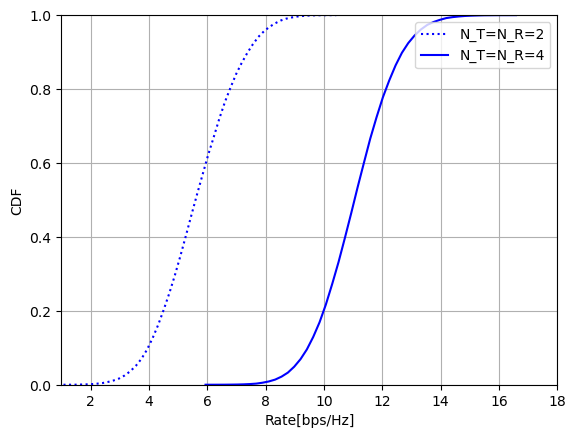

In [78]:


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

SNR_dB = 10
SNR_linear = np.power(10, SNR_dB/10.)
N_iter = 50000
sq2 = np.sqrt(0.5)
grps = ['b:', 'b-']
CDF = np.zeros((2, 50))
for Icase in range(0, 2):
  C = []
  if Icase==0: # 2x2
    nT=2
    nR=2
  else: # 4x4
    nT=4
    nR=4
  n = np.minimum(nT,nR)
  I = np.eye(n)
  for iter in range(1, N_iter+1):
    H = sq2*(np.random.randn(nR,nT) + 1j * np.random.randn(nR, nT))
    C.append(np.log2(np.real(np.linalg.det(I + (SNR_linear / nT) * np.matmul(H.conjugate().T, H)))))
  PDF, Rate = np.histogram(C, range=(np.nanmin(C), np.nanmax(C)), bins=50)
  Rate = Rate[:-1] + np.diff(Rate) / 2
  PDF = PDF / N_iter
  for i in range(50):
    CDF[Icase, i] = np.sum(PDF[1:i])
  plt.plot(Rate,CDF[Icase, :], grps[Icase])
plt.xlabel('Rate[bps/Hz]')
plt.ylabel('CDF')

plt.axis([1, 18, 0, 1])
plt.grid()
plt.rc('font', size=10)
plt.legend(["N_T=N_R=2", "N_T=N_R=4"], loc="upper right")
plt.show()

Program 9.2 “Ergodic_Capacity_vs_SNR.m” for ergodic channel capacity vs. SNR in Figure 9.6.

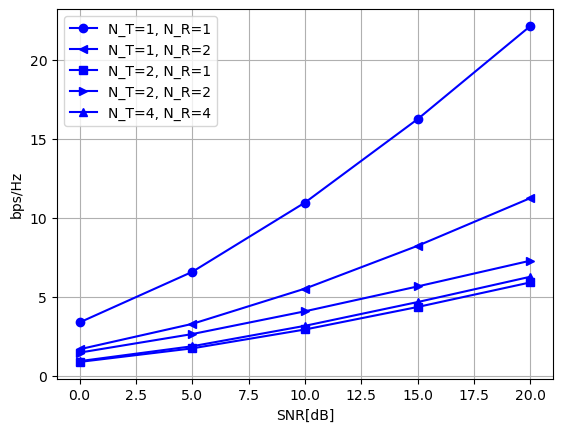

In [80]:

import numpy as np
import matplotlib.pyplot as plt

SNR_dB = list(range(0, 21, 5))
SNR_linear = np.power(10., np.divide(SNR_dB, 10.))
N_iter = 1000
C = np.zeros((5, len(SNR_dB)))
for Icase in range(5):
  if Icase==0: # 4x4
    nT=4
    nR=4
  elif Icase==1: # 2x2
    nT=2
    nR=2
  elif Icase==2: # 1x1
    nT=1
    nR=1
  elif Icase==3: # 1x2
    nT=1
    nR=2
  else: # 2x1
    nT=2
    nR=1
  n = np.minimum(nT,nR)
  I = np.eye(n);
  C[Icase, :] = np.zeros((1, len(SNR_dB)))
  for iter in range(N_iter):
    H = np.sqrt(0.5) * (np.random.randn(nR, nT) + 1j*np.random.randn(nR, nT)) 
    if nR >= nT:
      # print(H.shape)
      HH = np.matmul(H.conjugate().T, H)
    else:
      HH = np.matmul(H, H.conjugate().T)
    for i in range(len(SNR_dB)): # random channel generation
      C[Icase, i] = C[Icase, i] + np.log2(np.real(np.linalg.det(I + (SNR_linear[i] / nT) * HH)))

C = C / N_iter
# print(SNR_dB)
# print(C)
plt.plot(SNR_dB, C[0, :], 'b-o', SNR_dB, C[1, :], 'b-<', SNR_dB, C[2, :], 'b-s')
plt.plot(SNR_dB,C[3,:], 'b->', SNR_dB,C[4,:], 'b-^')
plt.xlabel('SNR[dB]')
plt.ylabel('bps/Hz')
plt.rc('font', size=10)
plt.grid()
s1='N_T=1, N_R=1'
s2='N_T=1, N_R=2' 
s3='N_T=2, N_R=1'
s4='N_T=2, N_R=2'
s5='N_T=4, N_R=4'
plt.legend([s1,s2,s3,s4,s5])
plt.show()

Program 9.4 “Water_Pouring” for water-pouring algorithm

In [178]:
def Water_Pouring(Lamda, SNR, nT):


  Gamma = np.zeros(len(Lamda))
  r = len(Lamda)
  index = list(range(r))
  index_temp = index
  p = 1
  # print(index_temp)
  while (p < r):
      irp = np.array(range(r-p+1))
      chosen_index_temp = [index_temp[x] for x in irp]
      chosen_Lamda = [Lamda[x] for x in chosen_index_temp]
      temp = 0
      for temp_chosen_Lamda in chosen_Lamda:
        temp += np.sum(np.divide(1., temp_chosen_Lamda)) # Lamda[index_temp[irp]]))
      mu = nT / (r - p + 1.) * (1 + ((1 / SNR) * temp))
      for temp_chosen_index_temp in chosen_index_temp:
        Gamma[temp_chosen_index_temp] = mu - np.sum(np.divide(nT, Lamda[temp_chosen_index_temp]))
      if np.min(Gamma[index_temp]) < 0:
        i = [i for i, x in enumerate(Gamma) if x == np.min(Gamma)]
        ii = [j for j, x in enumerate(index_temp) if x == i]
        index_temp2 = [index_temp[:i[0]-1], index_temp[i[0]:]]
        index_temp = index_temp2
        p = p+1
      else:
        p = r
  Gamma_t = np.zeros((len(Lamda)))
  Gamma_t[index_temp] = Gamma[index_temp]
  Gamma = Gamma_t;
  return Gamma

Program 9.3 “OL_CL_Comparison.m” for Ergodic channel capacity: open-loop vs. closedloop

In [179]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

SNR_dB = list(range(0, 21, 5))
SNR_linear = np.power(10, np.divide(SNR_dB, 10.))
N_iter = 1000
# ----------------- 4x4 -----------------------------
nT = 4
nR = 4
n = np.minimum(nT,nR)
I = np.eye(n)
rho = 0.2
sq2 = np.sqrt(0.5)
Rtx = [[1,                 rho,                np.power(rho, 2),   np.power(rho, 3)],
      [rho,                1,                  rho,                np.power(rho, 2)],
      [np.power(rho, 2),   rho,                1 ,                 rho],
      [np.power(rho, 3),   np.power(rho, 2),   rho,                1]]
rho = 0.2
Rrx = [[1,                 rho,                np.power(rho, 2),   np.power(rho, 3)],
      [rho,                1,                  rho,                np.power(rho, 2)],
      [np.power(rho, 2),   rho,                1 ,                 rho],
      [np.power(rho, 3),   np.power(rho, 2),   rho,                1]]

C_44_OL = np.zeros((1, len(SNR_dB)))
C_44_CL = np.zeros((1, len(SNR_dB)))
for iter in range(N_iter):
   Hw = sq2 * (np.random.randn(4, 4) + 1j*np.random.randn(4, 4))
   H = np.power(Rrx, (1/2)) * Hw * np.power(Rtx, (1/2))
   tmp = (H.conjugate().T * H) / nT
   SV = list(np.linalg.svd(np.multiply(H.conjugate().T, H)))
   for i in range(len(SNR_dB)): # random channel generation
      C_44_OL[i] = C_44_OL[i] + np.log2(np.linalg.det(I+SNR_linear[i]*tmp))
      Gamma = Water_Pouring(SV, SNR_linear[i], nT)
      C_44_CL[i] = C_44_CL[i] + np.log2(np.linalg.det(I+SNR_linear[i] / nT * np.linalg.diag(Gamma) * np.linalg.diag(SV)))
  
C_44_OL = np.real(C_44_OL) / N_iter
C_44_CL = np.real(C_44_CL) / N_iter
plt.plot(SNR_dB, C_44_OL, '-o', SNR_dB, C_44_CL, '-<')
plt.xlabel('SNR [dB]') 
plt.ylabel('bps/Hz')
plt.rc('font', size=10)
plt.legend(['Channel Unknown','Channel Known'],  loc="upper right")
plt.show()

C:\Users\sbida\AppData\Local\Temp\ipykernel_17360\1649143916.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  C_44_OL[i] = C_44_OL[i] + np.log2(np.linalg.det(I+SNR_linear[i]*tmp))
C:\Users\sbida\AppData\Local\Temp\ipykernel_17360\1571185357.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  Gamma[temp_chosen_index_temp] = mu - np.sum(np.divide(nT, Lamda[temp_chosen_index_temp]))


TypeError: list indices must be integers or slices, not list

 Program 9.5 “Ergodic_Capacity_Correlation.m:” Channel capacity reduction due to correlation

In [ ]:
#
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

SNR_dB = list(range(0, 21, 5))
SNR_linear = np.power(10, np.divide(SNR_dB, 10))

N_iter = 1000
N_SNR = len(SNR_dB)
# ----------------- 4x4 -----------------------------
nT = 4
nR = 4
n = np.minimum(nT, nR)
I = np.eye(n)
sq2 = np.sqrt(0.5)
R = [[1,                            0.76 * np.exp(0.17j * np.pi),   0.43 * np.exp(0.35j * np.pi),    0.25 * np.exp(0.53j * np.pi)],
   [0.76 * np.exp(-0.17j * np.pi),  1,                              0.76 * np.exp(0.17j * np.pi),    0.43 * np.exp(0.35j * np.pi)],
   [0.43 * np.exp(-0.35j * np.pi),  0.76 * np.exp(-0.17j * np.pi),  1,                               0.76 * np.exp(0.17j * np.pi)],
   [0.25 * np.exp(-0.53j * np.pi),  0.43 * np.exp(-0.35j * np.pi),  0.76 * np.exp(-0.17j * np.pi),   1                  ]]

C_44_iid = np.zeros((N_SNR))
C_44_corr = np.zeros((N_SNR))

for iter in range(0, N_iter):
  H_iid = sq2 * (np.random.randn(nR, nT) + 1j * np.random.randn(nR, nT))
  H_corr = np.matmul(H_iid, fractional_matrix_power(R, (1/2)))
  tmp1 = H_iid.T * (H_iid / nT)
  tmp2 = H_corr.T * (H_corr / nT)
  for i in range(0, N_SNR):
    C_44_iid[i] = C_44_iid[i] + np.log2(np.linalg.det(I + (SNR_linear[i] * tmp1)))
    C_44_corr[i] = C_44_corr[i] + np.log2(np.linalg.det(I + (SNR_linear[i] * tmp2)))
C_44_iid = np.real(C_44_iid) / N_iter
C_44_corr = np.real(C_44_corr) / N_iter
plt.plot(SNR_dB,C_44_iid, SNR_dB,C_44_corr,':');
plt.xlabel('SNR [dB]')
plt.ylabel('bps/Hz')
plt.rc('font', size=10)
plt.legend(['iid 4x4 channels','correlated 4x4 channels'])
plt.show()

# Chapter 10-Antenna Diversity and Space-Time Coding Techniques

Program 10.1 “MRC_scheme.m” for performance of MRC for Rayleigh fading channels

In [ ]:

import os

def modulator(bitseq, b):


  N_bits = bitseq.shape[1]
  if b==1:      # BPSK modulation
    sym_table = np.exp(np.dot(1j, [0, -np.pi]))
    sym_table = sym_table([1, 0] + 1)
    inp=bitseq
    mod_symbols = sym_table(inp + 1)
    M = 2
  elif b==2: # QPSK modulation
    sym_table = np.exp(np.dot(1j * np.pi / 4, [-3, 3, 1, -1]))
    sym_table = sym_table[[0, 1, 3, 2]]
    inp = np.reshape(bitseq, (b, N_bits // b))
    mod_symbols = sym_table[np.dot([2, 1], inp)]
    M = 4
  elif b==3:  # generates 8PSK symbols
    sym_table = np.exp(1j * np.pi / 4 * list(range(0, 8)))
    sym_table = sym_table([0, 1, 3, 2, 6, 7, 5, 4])
    inp = np.reshape(bitseq, (b, N_bits/b))
    mod_symbols=sym_table(np.dot([4, 2, 1], inp))
    mod_symbols = np.reshape(mod_symbols, (1, -1))
    M = 8
  elif b == 4:   # 16-QAM modulation
    m = 0
    sym_table = []
    sq10 = np.sqrt(10)
    for k in range(-3, 4, 2):
        for l in range(-3, 4, 2):
          sym_table.append(k+(1j*l)) / sq10 # power normalization

    sym_table = sym_table[[0, 1, 3, 2, 4, 5, 7, 6, 12, 13, 15, 14, 8, 9, 11, 10]] # Gray code mapping pattern for 8-PSK symbols
    inp = np.reshape(bitseq, (b, N_bits/b))
    mod_symbols = sym_table[np.dot([8, 4, 2, 1], inp)]  # maps transmitted bits into 16QAM symbols
    M=16 # 16 constellation points
  else:
    print('Unimplemented modulation')
    os.exit()
  return mod_symbols, sym_table, M


L_frame = 130
N_packet = 4000
b = 2 # Set to 1/2/3/4 for BPSK/QPSK/16QAM/64QAM
SNRdBs = np.arange(0, 21, 2)
sq2 = np.sqrt(2);
SNRdBs = np.arange(0, 21, 10)
sq2 = np.sqrt(2)
BER = np.zeros((3, len(SNRdBs)))
for iter in range(3):
    if iter == 0: # SISO
      NT = 1
      NR = 1
      gs = '-kx'
    elif iter==1: # Numbers of Tx/Rx antennas
      NT = 1
      NR = 2
      gs = '-^'
    else:
      NT=1
      NR=4
      gs = '-ro'
    sq_NT = np.sqrt(NT)
    for i_SNR in range(len(SNRdBs)):
      SNRdB = SNRdBs[i_SNR]
      sigma = np.sqrt(0.5 / np.power(10, (SNRdB / 10)))
      noeb_p = []
      for i_packet in range(N_packet):
         symbol_data = np.random.randint(low=0, high=2, size=(L_frame*b, NT))
         [temp,sym_tab,P] = modulator(symbol_data.T, b);
         X=temp.T   # frlg=length(X);
         Hr = (np.random.randn(L_frame,NR) + 1j*np.random.randn(L_frame, NR)) / sq2
         H = np.reshape(Hr, (L_frame, NR))
         Habs = np.sum(np.power(np.abs(H), 2), 1)
         Z = 0
         R = np.zeros((H.shape[0], NR))
         for i in range(NR):
            R[:, i] = np.sum(np.multiply(H[:,i], X), 0) / sq_NT + sigma * (np.random.randn(L_frame,1) + 1j*np.random.randn(L_frame, 1))[:, 0]
            Z = Z + np.multiply(R[:,i], H[:,i].conjugate())
         d1 = np.zeros((Z.shape[0], P))
         Z = np.reshape(Z, (-1, 1))
         for m in range(P):
            d1[:,m] = np.abs(np.sum(Z, 1) - np.power(sym_tab[m], 2)) + (-1 + np.sum(Habs, 0)) * np.power(np.abs(sym_tab[m]), 2)
         i1 = np.argmin(d1, axis=1)
         Xd=sym_tab[i1].T
         temp1 = X>0
         temp2 = Xd>0
         noeb_p.append(np.sum(np.sum(temp1!=temp2)))
      BER[iter, i_SNR] = np.sum(noeb_p)/(N_packet*L_frame*b)
    plt.semilogy(SNRdBs, BER[iter,:], gs)
    # plt.axis([SNRdBs[0], SNRdBs[-1], 1e-6, 1e0])
plt.title('BER perfoemancde of MRC Scheme')
plt.xlabel('SNR[dB]')
plt.ylabel('BER')
plt.rc('font', size=9)
plt.legend(['SISO','MRC (Tx:1,Rx:2)','MRC (Tx:1,Rx:4)'])
plt.show()


 Program 10.2 “modulator” for BPSK, QPSK, 8-PSK, 16-QAM mapping function

In [ ]:

import os

def modulator(bitseq, b):

  N_bits = bitseq.shape[1]
  if b==1:      # BPSK modulation
    sym_table = np.exp(np.dot(1j, [0, -np.pi]))
    sym_table = sym_table([1, 0] + 1)
    inp=bitseq
    mod_symbols = sym_table(inp + 1)
    M = 2
  elif b==2: # QPSK modulation
    sym_table = np.exp(np.dot(1j * np.pi / 4, [-3, 3, 1, -1]))
    sym_table = sym_table[[0, 1, 3, 2]]
    inp = np.reshape(bitseq, (b, N_bits // b))
    mod_symbols = sym_table[np.dot([2, 1], inp)]
    M = 4
  elif b==3:  # generates 8PSK symbols
    sym_table = np.exp(1j * np.pi / 4 * list(range(0, 8)))
    sym_table = sym_table([0, 1, 3, 2, 6, 7, 5, 4])
    inp = np.reshape(bitseq, (b, N_bits/b))
    mod_symbols=sym_table(np.dot([4, 2, 1], inp))
    mod_symbols = np.reshape(mod_symbols, (1, -1))
    M = 8
  elif b == 4:   # 16-QAM modulation
    m = 0
    sym_table = []
    sq10 = np.sqrt(10)
    for k in range(-3, 4, 2):
        for l in range(-3, 4, 2):
          sym_table.append(k+(1j*l)) / sq10 # power normalization

    sym_table = sym_table[[0, 1, 3, 2, 4, 5, 7, 6, 12, 13, 15, 14, 8, 9, 11, 10]] # Gray code mapping pattern for 8-PSK symbols
    inp = np.reshape(bitseq, (b, N_bits/b))
    mod_symbols = sym_table[np.dot([8, 4, 2, 1], inp)]  # maps transmitted bits into 16QAM symbols
    M=16 # 16 constellation points
  else:
    print('Unimplemented modulation')
    os.exit()
  return mod_symbols, sym_table, M


In [ ]:
Program 10.3 “Alamouti_scheme.m” for Alamouti space-time block coding

In [ ]:

import os

def modulator(bitseq, b):


  N_bits = bitseq.shape[1]
  if b==1:      # BPSK modulation
    sym_table = np.exp(np.dot(1j, [0, -np.pi]))
    sym_table = sym_table([1, 0] + 1)
    inp=bitseq
    mod_symbols = sym_table(inp + 1)
    M = 2
  elif b==2: # QPSK modulation
    sym_table = np.exp(np.dot(1j * np.pi / 4, [-3, 3, 1, -1]))
    sym_table = sym_table[[0, 1, 3, 2]]
    inp = np.reshape(bitseq, (b, N_bits // b))
    mod_symbols = sym_table[np.dot([2, 1], inp)]
    M = 4
  elif b==3:  # generates 8PSK symbols
    sym_table = np.exp(1j * np.pi / 4 * list(range(0, 8)))
    sym_table = sym_table([0, 1, 3, 2, 6, 7, 5, 4])
    inp = np.reshape(bitseq, (b, N_bits/b))
    mod_symbols=sym_table(np.dot([4, 2, 1], inp))
    mod_symbols = np.reshape(mod_symbols, (1, -1))
    M = 8
  elif b == 4:   # 16-QAM modulation
    m = 0
    sym_table = []
    sq10 = np.sqrt(10)
    for k in range(-3, 4, 2):
        for l in range(-3, 4, 2):
          sym_table.append(k+(1j*l)) / sq10 # power normalization

    sym_table = sym_table[[0, 1, 3, 2, 4, 5, 7, 6, 12, 13, 15, 14, 8, 9, 11, 10]] # Gray code mapping pattern for 8-PSK symbols
    inp = np.reshape(bitseq, (b, N_bits/b))
    mod_symbols = sym_table[np.dot([8, 4, 2, 1], inp)]  # maps transmitted bits into 16QAM symbols
    M=16 # 16 constellation points
  else:
    print('Unimplemented modulation')
    os.exit()
  return mod_symbols, sym_table, M

# Alamouti_scheme.py

import numpy as np
import matplotlib.pyplot as plt

L_frame = 130
N_Packets = 4000  # Number of frames/packet and Number of packets
NT = 2
NR = 1
b = 2
SNRdBs = np.arange(0, 31, 2)
sq_NT = np.sqrt(NT)
sq2 = np.sqrt(2)
noeb_p = []
BER = []
Habs = np.zeros((L_frame, NT))
for i_SNR in range(len(SNRdBs)):
    SNRdB = SNRdBs[i_SNR]
    sigma = np.sqrt(0.5 / (np.power(10, (SNRdB / 10))))
    for i_packet in range(N_Packets):  # loop for i_packet
        msg_symbol = np.random.randint(low=0, high=2, size=(L_frame * b, NT))
        tx_bits = msg_symbol.T
        tmp = []
        tmp1 = []
        for i in range(NT):
            [tmp1, sym_tab, P] = modulator(tx_bits[i:i + 1, :], b)
            tmp.append(tmp1)
        tmp = np.array(tmp)
        X = tmp.T
        X1 = X
        X2 = X1
        X2[:, 0] = -X[:, 1].conjugate()
        X2[:, 1] = X[:, 0].conjugate()
        X2 = np.array(X2)
        Hr = []
        for n in range(NT):
            Hr.append(np.random.randn(L_frame, NT) + 1j * np.random.randn(L_frame, NT) / sq2)
        Hr = np.array(Hr)
        H = np.reshape(Hr[NT - 1, :, :], (L_frame, NT))
        Habs[:, NT - 1] = np.sum(np.power(np.abs(H), 2), 1)
        x = np.sum(np.multiply(H, X1), 1) / sq_NT
        x = np.reshape(x, (-1, 1))
        R1 = x + sigma * (np.random.randn(L_frame, 1) + 1j * np.random.randn(L_frame, 1))
        y = np.sum(np.multiply(H, X2), 1) / sq_NT
        y = np.reshape(y, (-1, 1))
        R2 = y + sigma * (np.random.randn(L_frame, 1) + 1j * np.random.randn(L_frame, 1))
        Z1 = np.multiply(R1, H[:, 0:1].conjugate()) + np.multiply(R2.conjugate(), H[:, 1:2])
        Z2 = np.multiply(R1, H[:, 1:2].conjugate()) - np.multiply(R2.conjugate(), H[:, 0:1])
        d1 = d2 = np.zeros((Z1.shape[0], P))
        for m in range(P):
            tmp = np.dot(-1 + np.sum(Habs, 1), np.power(np.abs(sym_tab[m]), 2))
            d1[:, m] = np.power(np.abs(np.sum(Z1, 1) - sym_tab[m]), 2) + tmp
            d2[:, m] = np.power(np.abs(np.sum(Z2, 1) - sym_tab[m]), 2) + tmp

        i1 = np.argmin(d1, 1)
        S1d = sym_tab[i1].T

        i2 = np.argmin(d2, 1)
        S2d = sym_tab[i2].T

        Xd = np.array([S1d, S2d]).T
        tmp1 = X > 0
        tmp2 = Xd > 0
        noeb_p.append(np.sum(np.sum(tmp2)))  # for coded
    BER.append(np.sum(noeb_p) / (N_Packets * L_frame * b))

plt.semilogy(SNRdBs, BER)
# plt.axis([SNRdBs[0], SNRdBs[-1], 1e-6, 1e0])
plt.xlabel('SNR[dB]')
plt.ylabel('BER')
plt.show()


In [ ]:
Program 10.4 “STBC_3x4_simulation.m” to simulate 3x4 Space-Time Block Coding

In [ ]:


import os

def modulator(bitseq, b):


  N_bits = bitseq.shape[1]
  if b==1:      # BPSK modulation
    sym_table = np.exp(np.dot(1j, [0, -np.pi]))
    sym_table = sym_table([1, 0] + 1)
    inp=bitseq
    mod_symbols = sym_table(inp + 1)
    M = 2
  elif b==2: # QPSK modulation
    sym_table = np.exp(np.dot(1j * np.pi / 4, [-3, 3, 1, -1]))
    sym_table = sym_table[[0, 1, 3, 2]]
    inp = np.reshape(bitseq, (b, N_bits // b))
    mod_symbols = sym_table[np.dot([2, 1], inp)]
    M = 4
  elif b==3:  # generates 8PSK symbols
    sym_table = np.exp(1j * np.pi / 4 * list(range(0, 8)))
    sym_table = sym_table([0, 1, 3, 2, 6, 7, 5, 4])
    inp = np.reshape(bitseq, (b, N_bits/b))
    mod_symbols=sym_table(np.dot([4, 2, 1], inp))
    mod_symbols = np.reshape(mod_symbols, (1, -1))
    M = 8
  elif b == 4:   # 16-QAM modulation
    m = 0
    sym_table = []
    sq10 = np.sqrt(10)
    for k in range(-3, 4, 2):
        for l in range(-3, 4, 2):
          sym_table.append(k+(1j*l)) / sq10 # power normalization

    sym_table = sym_table[[0, 1, 3, 2, 4, 5, 7, 6, 12, 13, 15, 14, 8, 9, 11, 10]] # Gray code mapping pattern for 8-PSK symbols
    inp = np.reshape(bitseq, (b, N_bits/b))
    mod_symbols = sym_table[np.dot([8, 4, 2, 1], inp)]  # maps transmitted bits into 16QAM symbols
    M=16 # 16 constellation points
  else:
    print('Unimplemented modulation')
    os.exit()
  return mod_symbols, sym_table, M


Program 10.5 “STTC_simulation.m” to simulate the STTC (Space-Time Trellis Coding)

Program 10.6 “STTC_stage_modulator”

Program 10.7 “data_generator”

Program 10.8 “trellis_encoder”

Program 10.9 “STTC_modulator”

Program 10.10 “channel1”: channel generation for STTC (Space-Time Trellis Code)

Program 10.11 “STTC_detector”: STTC (Space-Time Trellis Code) detector

# Chapter 11- Signal Detection for Spatially Multiplexed MIMO Systems

Program 11.1 “OSIC_detector” implementing the various OSIC signal detection methods

In [ ]:


from scipy.linalg import inv, norm


def OSIC_detector(y, H, sigma2, nT, OSIC_type):
  # Input parameters
  #   y     : Received signal, nRx1
  #   H     : Channel matrix, nRxnT
  #   sigma2: Noise variance
  #   nT    : Number of Tx antennas
  #   OSIC_type
  #       - 1 : Post_detection_SINR
  #       - 2 : Column_max
  #       - 3 : Post_detection_SNR
  # Output parameter
  #   X_hat : Estimated signal,nTx1


  nT=4

  if OSIC_type==1:  # Post_detection_SINR
    Order = [] # detection order
    index_array = np.arange(nT) # yet to be detected signal index
    # V-BLAST
    x_temp = []
    X_hat = []
    for stage in range(len(nT)):
      Wmmse = inv(H.T * H + sigma2 * np.eye(nT+1-stage)) * H.T  # MMSE filter
      WmmseH = Wmmse * H
      SINR = []
      for i in range(nT-(stage-1)):
          tmp = np.power(norm(WmmseH[i, [np.arange(i-1), np.arange(i+1, nT-(stage-1))]]), 2) + sigma2 * np.power(norm(Wmmse[i,:]), 2)
          SINR[i] = np.power(np.abs(WmmseH[i, i]), 2) / tmp  # SINR calculation
      
      index_temp = np.argmax(SINR)    # ordering using SINR
      Order = np.append(index_array[index_temp])
      index_array = index_array[[np.arange(index_temp-1), index_temp+1]]
      x_temp.append(Wmmse[index_temp,:] * y)     # MMSE filtering
      X_hat.append(QAM16_slicer(x_temp[stage], 1))   # slicing
      y_tilde = y - H[:,index_temp] * X_hat[stage]   # interference subtraction
      H_tilde = H[:, np.arange(index_temp-1), np.arange(index_temp+1, nT-(stage-1))]  # new H
      H = H_tilde
      y = y_tilde

    X_hat[Order] = X_hat
  elif OSIC_type==2:   # column_norm ordering detection
    X_hat = np.zeros((nT,1))
    G = inv(H)           # inverse of H
    for i in range(len(nT)):           # column_norm calculation
      norm_array[i] = norm(H[:,i])

    sorted_norm_array, Order_temp = np.sort(norm_array)
    Order = wrev(Order_temp)
    # V-BLAST
    for stage in range(len(nT)):
        x_temp = G[Order[stage],:] * y    # Tx signal estimation
        X_hat[Order[stage]] = QAM16_slicer(x_temp, 1)  # slicing
        y_tilde = y - H[:,Order[stage]] * X_hat[Order[stage]]

  else: # OSIC with Post_detection_SNR ordering
    Order=[]  
    index_array = np.arange(nT)   # set of indices of signals to be detected
    # V-BLAST
    for stage in range(len(nT)):
      G = inv(H.T * H) * H.T
      norm_array = []
      for i in range(nT-(stage-1)): # detection ordering
          norm_array.append(norm(G[i,:]))
      
      index_min = np.argmin(norm_array)  # ordering in SNR
      Order.append(index_array[index_min])
      index_array = index_array[0:index_min-1, index_min+1:]
      x_temp[stage] = G[index_min, :] * y  # Tx signal estimation
      X_hat[stage] = QAM16_slicer(x_temp[stage], 1)  # slicing
      y_tilde = y - H[:, index_min] * X_hat[stage]  # interference subtraction
      H_tilde = H[:, [np.arange(index_min-1), np.arange(index_min+1, nT-(stage-1))]]  # new H
      H = H_tilde
      y = y_tilde
    X_hat[Order] = X_hat
  return X_hat


Program 11.2 “QAM16_slicer”

In [ ]:

from PIL import Image

def QAM16_slicer(X, N=None):

# MIMO-OFDM Wireless Communications with MATLAB¢ç   Yong Soo Cho, Jaekwon Kim, Won Young Yang and Chung G. Kang
# 2010 John Wiley & Sons (Asia) Pte Ltd

  if N is None:
    N = len(X) 
  sq10 = np.sqrt(10)
  b = np.divide([-2, 0, 2], sq10)
  c = np.divide([-3, -1, 1, 3], sq10)
  Xr = np.real(X)
  Xi = np.imag(X)
  for i in range(len(N)):
    R[np.where(Xr < b[0])] = c[0]
    I[np.where(Xi < b[0])] = c[0]
    R[np.where(np.logical_and(b[0]<=Xr, Xr<b[1]))] = c[1]
    I[np.where(np.logical_and(b[0]<=Xi, Xi<b[1]))] = c[1]
    R[np.where(np.logical_and(b[1]<=Xr, Xr<b[2]))] = c[2]
    I[np.where(np.logical_and(b[1]<=Xi, Xi<b[2]))] = c[2]
    R[np.where(b[2] <= Xr)] = c[3]
    I[np.where(b[2] <= Xi)] = c[3]

  X_hat = R + j * I
  return X_hat

Program 11.3 “ML_detector” for ML signal detection

In [ ]:


def ML_detector(y, H):
  QAM_table = np.divide([-3-3j, -3-1j, -3+3j, -3+1j, -1-3j, -1-1j, -1+3j, -1+1j, 3-3j, 3-1j, 3+3j, 3+1j, 1-3j, 1-1j, 1+3j, 1+1j], np.sqrt(10))
  metric = 100000
  for l in range(16):
    x_tmp[0] = QAM_table[0]
    Esti_y1[:, 0] = y - H[:, 0] * x1_tmp
    for m in range(16):
      x_tmp[1] = QAM_table[m]
      Esti_y2[:, 0] = Esti_y1[:, 0] - H[:, 1] * x2_tmp
      for n in range(16):
        x_tmp[2] = QAM_table[n]
        Esti_y3[:, 0] = Esti_y2[:, 0] - H[:, 2] * x3_tmp
        for o in range(16):
          x_tmp[3] = QAM_table[o]
          Esti_y4[:, 0] = Esti_y3[:, 0] - H[:, 3] * x4_tmp
          metric_tmp = np.sqrt(Esti_y4[:, 0].T *Esti_y4[:, 0])
          if metric_tmp < metric:
            X_hat = x_tmp
            metric = metric_tmp
  return X_hat


Program 11.4 “SD_detector”

In [ ]:


def SD_detector(y, H, nT):
  # Input parameters
  #     y : received signal, nRx1
  #     H : Channel matrix, nRxnT
  #    nT : number of Tx antennas
  # Output parameter
  #    X_hat : estimated signal, nTx1

  
  global x_list         # candidate symbols in real constellations
  global x_now          # temporary x_vector elements
  global x_hat          # inv(H)*y
  global x_sliced       # sliced x_hat
  global x_pre          # x vectors obtained in the previous stage
  global real_constellation # real constellation
  global R               # R in the QR decomposition
  global radius_squared  # radius^2
  global x_metric        # ML metrics of previous stage candidates
  global len             # nT * 2
  QAM_table2 = [-3-3j, -3-1j, -3+3j, -3+1j, -1-3j, -1-1j, -1+3j, -1+1j,3-3j, 3-1j, 3+3j, 3+1j, 1-3j, 1-1j, 1+3j, 1+1j] / np.sqrt(10)  # 16-QAM
  real_constellation = [-3, -1, 1, 3] / np.sqrt(10)
  y = [np.real(y), np.imag(y)]     # y : complex vector  -> real vector
  H = [[np.real(H)  -(np.imag(H))], [np.imag(H), np.real(H)]]
  # H : complex vector  -> real vector
  len = nT * 2  # complex -> real
  x_list = np.zeros((len, 4))  # 4 : real constellation length, 16-QAM
  x_now = np.zeros((len, 1))
  x_hat = np.zeros((len, 1))
  x_pre = np.zeros((len, 1))
  x_metric = 0
  [Q,R] = np.linalg.qr(H)     # nR x nT QR decomposition
  x_hat = np.inv(H) * y       # zero forcing equalization
  x_sliced = QAM16_real_slicer(x_hat,len).T  # slicing
  radius_squared = np.power(np.linalg.norm(R*(x_sliced-x_hat)), 2)  # Radious^2
  transition = 1
  # meaning of transition 
  # 0 : radius*2, 1~len : stage number
  # len+1 : compare two vectors in terms of norm values
  # len+2 : finish
  flag = 1 
  # transition tracing 0 : stage index increases by +1 
  #1 : stage index decreases by -1 
  #2 : 1->len+2 or len+1->1
  while (transition < len+2):
    if transition==0:    # radius_squared*2
      [flag,transition,radius_squared,x_list]= radius_control(radius_squared, transition)
    elif transition <= len:
      flag, transition = stage_processing(flag,transition)
    elif transition == len+1:  
      [flag,transition] = compare_vector_norm(transition)
  ML = x_pre
  for i in range(len/2):
      X_hat[i] = ML[i] + j * ML[i + len/2]
  return X_hat


Program 11.5 “state_processing”

In [ ]:


def stage_processing(flag, transition):
  # Input parameters
  #    flag : previous stage index
  #       flag = 0 : stage index decreased -> x_now empty -> new x_now
  #       flag = 1 : stage index decreased -> new x_now
  #       flag = 2 : previous stage index =len+1 ->  If R>R'? start from the first stage
  #     transition : stage number
  # Output parameters
  #     flag : stage number is calculated from flag
  #     transition : next stage number, 0 : R*2, 1: next stage, len+2: finish

  global x_list
  global x_metric
  global x_now
  global x_hat
  global real_constellation
  global R
  global radius_squared
  global x_sliced
  
  stage_index = len(R[0,:]) - (transition-1) 
  if flag == 2:  # previous stage=len+1 : recalculate radius R'
    radius_squared  = np.power(np.linalg.norm(R * (x_sliced - x_hat)), 2)

  if flag != 0:  # previous stage=len+1 or 0 
  # -> upper and lower bound calculation, x_list(stage_index,:)
      [bound_lower, bound_upper] = bound(transition)
      for i in range(4):    # search for a candidate in x_now(stage_index),
        # 4=size(real_constellation), 16-QAM assumed
        if bound_lower <= real_constellation[i] and real_constellation[i] <= bound_upper:
          list_len = list_length(x_list[stage_index, :])
          x_list[stage_index, list_len+1] = real_constellation[i]
       
  list_len = list_length(x_list[stage_index,:])
  if list_len == 0:     # no candidate in x_now
    if x_metric == 0 or transition != 1: 
      # transition >=2 ? if no candidate ? decrease stage index
      flag = 0
      transition = transition - 1
    elif x_metric != 0 and transition == 1: 
      # above two conditions are met? ML solution found
      transition = len(R[0,:]) + 2  # finish stage

  else:              # candidate exist in x_now ? increase stage index
    flag = 1
    transition = transition + 1
    x_now[stage_index] = x_list[stage_index, 0]
    x_list[stage_index, :] = [[x_list[stage_index [1: 4]]], 0]

  return flag, transition


Program 11.6 “list_length”

In [ ]:
def list_length(list_inp):
  # Input parameter
  #     list_inp : vector type
  # Output parameter
  #     len : index number

  len = 0
  for i in range(4):
    if list_inp[i]==0:
      break
    else:
      len = len+1
  return len

Program 11.7 “bound”

In [ ]:


def bound(transition):
  # Input parameters
  #     R : [Q R] = qr(H)
  #     radius_squared : R^2
  #     transition : stage number
  #     x_hat : inv(H)*y
  #     x_now : slicing x_hat
  # Output parameters
  #     bound_lower : bound lower
  #     bound_upper : bound upper

  global R,  radius_squared,  x_now,  x_hat
  len = len(x_hat)
  temp_sqrt = radius_squared
  temp_k = 0
  for i in range(transition-1):
    temp_abs = 0
    for k in range(i):
        index_1 = len - (i-1)
        index_2 = index_1 + (k-1)
        temp_k = R[index_1,index_2] * (x_now[index_2] - x_hat[index_2])
        temp_abs = temp_abs + temp_k

    temp_sqrt = temp_sqrt - np.power(np.abs(temp_abs), 2)

  temp_sqrt = np.sqrt(temp_sqrt)
  temp_no_sqrt = 0
  index_1 = len-(transition-1)
  index_2 = index_1
  for i in range(transition-1):
    index_2 = index_2 + 1
    temp_i = R[index_1, index_2] * (x_now[index_2] - x_hat[index_2])
    temp_no_sqrt = temp_no_sqrt - temp_i

  temp_lower = -temp_sqrt + temp_no_sqrt
  temp_upper = temp_sqrt + temp_no_sqrt
  index = len-(transition-1)
  bound_lower = temp_lower / R[index,index] + x_hat[index]
  bound_upper = temp_upper / R[index,index] + x_hat[index]
  bound_upper = np.fix(bound_upper * np.sqrt(10)) / np.sqrt(10)  
  bound_lower = np.ceil(bound_lower * np.sqrt(10)) / np.sqrt(10) 
  return bound_lower, bound_upper

Program 11.8 “radius_control”

In [ ]:

def radius_control(radius_squared, transition):
  # Input parameters
  #     radius_squared : current radius
  #     transition : current stage number
  # Output parameters
  #     radius_squared : doubled radius
  #     transition : next stage number
  #     flag : next stage number is calculated from flag
  global len
  radius_squared = radius_squared * 2;
  transition = transition+1
  flag = 1
  x_list[len, :] = np.zeros(1,4)
  return flag, transition, radius_squared, x_list

Program 11.9 “vector_comparison”

Program 11.10 “compare_vector_norm”

Program 11.11 “QRM_MLD_detector”

Program 11.12 “stage_processing1”

In [ ]:

def stage_processing(flag, transition):
 
  global x_list
  global x_metric
  global x_now
  global x_hat
  global real_constellation
  global R
  global radius_squared
  global x_sliced
  
  stage_index = len(R[0,:]) - (transition-1) 
  if flag == 2:  # previous stage=len+1 : recalculate radius R'
    radius_squared  = np.power(np.linalg.norm(R * (x_sliced - x_hat)), 2)

  if flag != 0:  # previous stage=len+1 or 0 
  # -> upper and lower bound calculation, x_list(stage_index,:)
      [bound_lower, bound_upper] = bound(transition)
      for i in range(4):    # search for a candidate in x_now(stage_index),
        # 4=size(real_constellation), 16-QAM assumed
        if bound_lower <= real_constellation[i] and real_constellation[i] <= bound_upper:
          list_len = list_length(x_list[stage_index, :])
          x_list[stage_index, list_len+1] = real_constellation[i]
       
  list_len = list_length(x_list[stage_index,:])
  if list_len == 0:     # no candidate in x_now
    if x_metric == 0 or transition != 1: 
      # transition >=2 ? if no candidate ? decrease stage index
      flag = 0
      transition = transition - 1
    elif x_metric != 0 and transition == 1: 
      # above two conditions are met? ML solution found
      transition = len(R[0,:]) + 2  # finish stage

  else:              # candidate exist in x_now ? increase stage index
    flag = 1
    transition = transition + 1
    x_now[stage_index] = x_list[stage_index, 0]
    x_list[stage_index, :] = [[x_list[stage_index [1: 4]]], 0]

  return flag, transition


Program 11.13 “calculate_norm”

Program 11.14 “sort_matrix”

Program 11.15 “LRAD_MMSE” for Lattice Reduction-Aided Detector with MMSE
detection

Program 11.16 “original_LLL”

Program 11.17 “SQRD”

Program 11.18 “soft_hard_SISO.m”: Hard/soft-decision detection for SISO system

Program 11.19 “soft_decision_sigma”: soft Viterbi decoding for SISO system

Program 11.20 “MMSE_detection_2x2.m”: MMSE detection for 2  2 MIMO system

Program 11.21 “soft_output2x2”: Soft output of MMSE detector for 2  2 MIMO system

Program 11.22 “QRM_MLD_simulation.m”

Program 11.23 “QRM_MLD_soft”: Soft decision performance of QRM-MLD

Program 11.24 “QAM16_slicer_soft”

## Chapter 12- Exploiting Channel State Information at the Transmitter Side

Program 12.1 “codebook_generator” for codebook generation

In [ ]:

import math

N_Nt=4; 
N_M=2; 
N_L=64;
code_book = np.array(ndim=3)
cloumn_index= np.array([0,1]) #changed index to 0 and 1
rotation_vector= np.array([1,7,52,56])

#kk=0:N_Nt-1;ll=0:N_Nt-1;
kk = np.arange(0, N_Nt)
ll = np.arange(0, N_Nt)

w = np.exp((1j)*2*math.pi/N_Nt*np.transpose(np.atleast_2d(kk))*np.atleast_2d(ll))/(math.sqrt(N_Nt));
w_1 = w[:][cloumn_index]
print(w_1)

theta = np.diag(np.exp(1j*2*math.pi/N_L*rotation_vector));
code_book[:][:][1] = np.array(w_1)

for i in range(0,N_L):
    code_book[:][:][i+1] = theta*code_book[:][:][i]

Program 12.2 “Alamouti_2x1_precoding.m” for Alamouti coding with precoded OSTBC

In [ ]:

from numpy.random import default_rng
import matplotlib as mtplib
from matplotlib.axis import YAxis

import matlab.engine
eng=matlab.engine.start_matlab()

#Number of frames/packet and Number of packets
N_frame=1000
N_packet=100

#Number of bits per symbol and Modulation order
b=2; 
M=2**b;"""
mod_obj=eng.qammod(M,M,SymbolOrder,Gray,InputType,bit);
demod_obj = modem.qamdemod(mod_obj);
"""
#MIMO Parameters
T_TX=4
code_length=64
NT=2 
NR=1 # Numbers of transmit/receive antennas
N_pbits=NT*b*N_frame
N_tbits=N_pbits*N_packet
cal = []
#code_book = codebook_generator;

print("====================================================\n");
print(" Precoding transmission");
print("\n {0} x {1} MIMO\n {2} QAM".format(NT,NR,M));
print("\n Simulation bits : {0}".format(N_tbits));
print("\n====================================================\n");


SNRdBs = np.array(0,2,20, ndim=3)#check
sq2=math.sqrt(2)

for i_SNR in range(1,len(SNRdBs)+1): #AD#how does matrix have length
    SNRdB = SNRdBs(i_SNR) #I element of SNRdBs
    noise_var = NT*0.5*(10**(-SNRdB/10))
    sigma = math.sqrt(noise_var)
    rng = default_rng(1) #rand(’seed’,1) & randn(’seed’,1); #AD#are legacy commands and used anymore - https://www.mathworks.com/help/matlab/math/updating-your-random-number-generator-syntax.html
    N_ebits=0
    
    for i_packet in range(1,N_packet+1):#upper bound included or not
        msg_bit = rng.random(N_pbits,1) # Bit generation, #AD#specify min and max
        #%%%%%%%%%%%%% Transmitter %%%%%%%%%%%%%%%%%%
        #s = mlb.modulate(mod_obj, msg_bit );
        #Scale = modnorm(s,’avpow’,1); # Normalization #AD# should work with matlab.engine
        S = np.reshape(Scale*s,(NT,1,N_frame)); # Transmit symbol
        #Tx_symbol = [S(1,1,:) -conj(S(2,1,:)); S(2,1,:) conj(S(1,1,:))];
        #%%%%%%%%%%%%% Channel and Noise %%%%%%%%%%%%%
        H = (np.random.randn(NR,T_TX)+1j*np.random.randn(NR,T_TX))/sq2;
        for i in range(1,code_length+1)
            cal[i] = np.norm(H*code_book[:,:,i],'fro')
        [val,Index] = cal.max()
        He = H*code_book[:,:,Index];
        norm_H2 = norm(He)**2; # H selected and its norm2
        for i  in range(1,N_frame+1):
            Rx[:,:,i]=He*Tx_symbol[:,:,i]+sigma*(np.random.randn(NR,2)+1j*np.random.randn(NR,2));
            #%%%%%%%%%%%%% Receiver %%%%%%%%%%%%%%%%%%
        for i in range(1,N_frame+1):
            #y[1,i] = (He(1)’*Rx(:,1,i)+He(2)*Rx(:,2,i)’)/norm_H2;
            #y[2,i] = (He(2)’*Rx(:,1,i)-He(1)*Rx(:,2,i)’)/norm_H2;
        S_hat = np.reshape(y/Scale,NT*N_frame,1);
        #msg_hat = demodulate(demod_obj,S_hat);
        #N_ebits = N_ebits + sum(msg_hat=msg_bit);
    BER[i_SNR] = N_ebits/N_tbits;

pre_mmse = mtplib.plot(SNRdBs, BER) #’-k^’, ’LineWidth’,2); hold on; grid on;
mtplib.scaleLogScale(YAxis)
mtplib.xlabel("SNR[dB]")
mtplib.ylabel("BER")
mtplib.title("Precoded Alamouti")

Program 12.3 “pre_MMSE.m” for Pre-MMSE equalization

In [ ]:
import math
import numpy as np
from numpy.random import default_rng
import matplotlib as mtplib
from matplotlib.axis import YAxis

#%%%%%% Parameter Setting %%%%%%%%%
N_frame=100
N_packet=1000
b=2 
M=2**b
NT=4
NR=4  
sq2=math.sqrt(2)
I=np.identity(NR)
N_pbits = N_frame*NT*b;
N_tbits = N_pbits*N_packet
print("====================================================\n");
print("Pre-MMSE transmission");
print("\n  {0} x {1} MIMO\n  {2} QAM".format(NT,NR,M));
print("\n  Simulation bits : {0}".format(N_tbits));
print("\n====================================================\n");
SNRdBs = np.array(0,2,20, ndim=3);#AD#check
Es=1; 
A=math.sqrt(3/2/(M-1)*Es);
Symbol_nomalized=[];
BER = np.array(ndim=1)
for i_SNR in range(1,len(SNRdBs)+1):#AD#upper bound included or not, which dim in SNRdBs
   SNRdB = SNRdBs[i_SNR];#AD#SNRdbs has 3 dim so which on does i refer to ?
   noise_var = NT*0.5*10^(-SNRdB/10); 
   sigma = math.sqrt(noise_var);
   rng = default_rng(1)
   N_ebits = 0; 
   #%%%%%%%%%%%%% Transmitter %%%%%%%%%%%%%%%%%%
   for i_packet in range(1,N_packet+1):#AD#upper bound included or not
      msg_bit =rng.random(N_pbits,1); #% bit generation
      #symbol = qammod(msg_bit,M);
      #symbol = modulate(mod_obj,msg_bit).';
      #Scale = modnorm(symbol,'avpow',1); % normalization
      #Symbol_nomalized = np.reshape(Scale*symbol,(NT,N_frame) #AD# check 
      H = (np.random.randn(NR,NT)+1j*np.random.randn(NR,NT))/sq2
      temp_W = H.getH()*(H*H.getH()+noise_var*I).getI(); #AD#check inverse and complex conjugate matrix operations
      beta = math.sqrt(NT/trace(temp_W*temp_W.getH())); #% Eq.(12.17)
      W = beta*temp_W  
      Tx_signal = W*Symbol_nomalized;  
      #%%%%%%%%%%%%% Channel and Noise %%%%%%%%%%%%%        
      Rx_signal = H*Tx_signal+sigma*(np.random.randn(NR,N_frame)+1j*np.random.randn(NR,N_frame));
      #%%%%%%%%%%%%%% Receiver %%%%%%%%%%%%%%%%%%%%%
      y = Rx_signal/beta; #% Eq.(12.18
      Symbol_hat = np.reshape(y/Scale,(NT*N_frame,1));
      #msg_hat = demodulate(demod_obj,Symbol_hat);
      #N_ebits = N_ebits + sum(msg_hat~=msg_bit);
    BER[i_SNR] = N_ebits/N_tbits

"""semilogy(SNRdBs,BER,'-k^','LineWidth',2); hold on; grid on;
#xlabel('SNR[dB]'), ylabel('BER'); #add marker ?
#legend('Pre-MMSE transmission')"""
pre_mmse = mtplib.plot(SNRdBs, BER)
mtplib.scaleLogScale(YAxis)
mtplib.xlabel("SNR[dB]")
mtplib.ylabel("BER")
mtplib.title("Pre-MMSE transmission")

Program 12.4 “MIMO_channel_cap_ant_sel_optimal.m” for channel capacity with the
optimal antenna selection method

In [ ]:
import math
from numpy.random import default_rng
import matplotlib as mtplib

NT=4
NR=4
MaxIter=1000
I=np.identity(NR);
sel_capacity = np.array()
log_SH = np.array(ndim=1)
sq2=math.sqrt(2); 
#gss=['-ko';'-k^';'-kd';'-ks'];
SNRdBs=np.array(0,2,20, ndim=3);
for sel_ant in range(1,5):#upper bound included or not
   for i_SNR in (1,len(SNRdBs)+1):
      SNRdB = SNRdBs[i_SNR];
      SNR_sel_ant = 10**(SNRdB/10)/sel_ant;   
      rng = default_rng(1)
      cum = 0
      for i in range(1,MaxIter+1):
        H = (np.random.randn(NR,NT)+1j*np.random.randn(NR,NT))/sq2;
        if sel_ant>NT and sel_ant<1: print("Error- sel_ant must be between 1 and NT!")
        else: indices = scipy.special.binom(np.array(1,NT),sel_ant);
        for n in range(1,np.prod(indices,axis=1)+1):
            #Hn = H[:,indices(n,:)]; 
            log_SH[n]=np.log2(np.real(np.linalg.det(I+SNR_sel_ant*Hn*Hn))); #% Eq.(12.22)
        cum = cum + log_SH.max();
        sel_capacity[i_SNR] = cum/MaxIter;
"""plot(SNRdBs,sel_capacity,gss(sel_ant,:), 'LineWidth',2); hold on;
xlabel('SNR[dB]'), ylabel('bps/Hz'), grid on;
legend('sel-ant=1','sel-ant=2','sel-ant=3','sel-ant=4')"""

mtplib.plot(SNRdBs, sel_capacity)#AD# add gss(sel_ant,:), 'LineWidth',2); hold on;
mtplib.xlabel("SNR[dB]")
mtplib.ylabel("bps/Hz")
mtplib.title("Pre-MMSE transmission")

Program 12.5 “MIMO_channel_cap_ant_sel_subopt.m” for channel capacity with the
suboptimal antenna selection method

In [ ]:
import math
from numpy.random import default_rng
import matplotlib as mtplib

sel_ant=2; #% Number of antennas to select 
sel_method=0; #% 0/1 for increasingly/decreasingly ordered selection
NT=4; NR=4; #% Number of transmit/receive antennas
I=np.identity(NR);
log_SH = np.array() 
sq2=math.sqrt(2);
SNRdBs = np.array(0,10); 
MaxIter=1000;   
for i_SNR in range(1,len(SNRdBs)+1):
   SNRdB = SNRdBs[i_SNR];  
   SNR_sel_ant = 10**(SNRdB/10)/sel_ant;   
   rng = default_rng(1)
   cum = 0;
   for i in range(1,MaxIter+1):
        if sel_method==0:
            sel_ant_indices=[];
            rem_ant_indices=np.arange(1, NT);
        else: 
            sel_ant_indices=np.arange(1, NT);
            del_ant_indices=[];
        H = (np.random.randn(NR,NT)+1j*np.random.randn(NR,NT))/sq2;
        if sel_method==0 #%increasingly ordered selection method
            for current_sel_ant_number in range(1,sel_ant+1):
                #clear log_SH;
                for n in range(1,len(rem_ant_indices)+1):
                    #Hn = H(:,[sel_ant_indices rem_ant_indices(n)]); 
                    log_SH[n] = np.log2(np.real(np.linalg.det(I+SNR_sel_ant*Hn*Hn)));
            maximum_capacity = log_SH.max();
            #selected = find(log_SH==maximum_capacity);
            sel_ant_index = rem_ant_indices(selected);
            rem_ant_indices = [rem_ant_indices[1:selected-1] rem_ant_indices[selected+1:end]];    
            sel_ant_indices = [sel_ant_indices sel_ant_index];
        else #%decreasingly ordered selection method
            for current_del_ant_number in range(1,NT-sel_ant+1):
                #clear log_SH;
                for n in range(1,len(sel_ant_indices)+1):
                    #Hn = H(:,[sel_ant_indices(1:n-1) sel_ant_indices(n+1:end)]); 
                    log_SH[n] = np.log2(np.real(np.linalg.det(I+SNR_sel_ant*Hn*Hn))); 
            maximum_capacity = log_SH.max();
           #selected = find(log_SH==maximum_capacity);
           #sel_ant_indices = [sel_ant_indices(1:selected-1) sel_ant_indices(selected+1:end)];                    
        cum = cum + maximum_capacity;
   sel_capacity[i_SNR] = cum/MaxIter;

mtplib.plot(SNRdBs, sel_capacity)#AD# add gss(sel_ant,:), 'LineWidth',2); hold on;
mtplib.xlabel("SNR[dB]")
mtplib.ylabel("bps/Hz")
mtplib.title("Capacity of suboptimally selected antennas")

Program 12.6 “Alamouti_2x1_ant_selection.m”: Antenna selection for OSTBC

## Chapter 13- Multi-User MIMO

Program 13.1 “multi_user_MIMO.m” for a multi-user MIMO system with channel inversion

Program 13.2 “QPSK_mapper”

Program 13.3 “QPSK_slicer”

Program 13.4 “QPSK_demapper”

Program 13.5 “Block_diagonalization.m” for BD method using zero-forcing detection

Program 13.6 “Dirty_or_TH_precoding.m”: DPC or THP for a multi-user MIMO system

Program 13.7 “modulo”: Modulo function for Tomlinson-Harashima Precoding (THP)